# Importing functions and data

## file locations

Supplementary Table 1 must be in the same directory as this notebook, or you will need to change this address!  
Similarly so does the FosJun reference structure

In [1]:
table_S1 = '../../../../Analysis/submission/supplementary_tables/TableS1_epistasis_all_double_mutants.xlsx'
#'../../Supplementary Tables/TableS1_epistasis_all_double_mutants.xlsx'
fosjun_xtal = '../../../../Analysis/submission/additional_data/fosjun_docking/experimental_structure/1FOS_fosjun.pdb'

Outputs from this notebook go to certain directories- uncomment these to make them here:

In [1080]:
# ! mkdir ./results/
# ! mkdir ./results/plots/
# ! mkdir ./results/tables/
# ! mkdir ./results/plots/fitness_distributions
# ! mkdir ./results/plots/data_completeness
# ! mkdir ./results/plots/epi_dists
# ! mkdir ./supplementary_figures/secondary_structure
# ! mkdir ./additional_data/gb1_subsampling/precision

## imports

Required python modules, and custom scripts are in "DMS_to_3D.py"

In [2]:
from DMS_to_3D import *
sns.set_style('whitegrid')
%matplotlib inline

## load in mutation scans

load in paper datasets from supplemental table

In [3]:
epistasis_tables = pd.ExcelFile(table_S1)

gb1 = load_sheet(epistasis_tables, 1)
ww = load_sheet(epistasis_tables, 2)
rrm = load_sheet(epistasis_tables, 3)
twister = load_sheet(epistasis_tables, 4)
fosjun = load_sheet(epistasis_tables, 5)
gfp = load_sheet(epistasis_tables, 6)

label long-range mutants, and filter out early stop mutants

In [197]:
rrm.loc[:, 'LR'] = rrm['positions'].apply(lambda x: np.abs(x[1] - x[0]) > 5)


In [4]:
# label the long-range mutants
for dms in [gb1, ww, rrm, twister, fosjun, gfp]:
    dms.loc[:, 'LR'] = dms['positions'].apply(lambda x: np.abs(x[1] - x[0]) > 5)

# exclude early stop mutations
ww = ww[~ww['mut'].apply(lambda x: '*' in str(x))]
rrm = rrm[~rrm['mut'].apply(lambda x: '*' in str(x))]

In [48]:
fosjun.loc[:, 'fit.proj.thermo'] = fosjun['double.mut.fit'] - fosjun['mepi_thermo']

fosjun.loc[:, 'Ws'] = fosjun.apply(
    lambda x: (x['fos.mut.fit'], x['jun.mut.fit']),
axis = 1)

## load in example xtal structures

For comparison, for each residue-residue pair in experimental structures, load in the nearest distances between heavy atoms.

In [5]:
gb1_pdbs = [('1gb1', 'A', 226), ('1igd', 'A', 226-5),
            ('1pga', 'A', 226), ('1pgb', 'A', 226),
            ('2gb1', 'A', 226), ('2igd', 'A', 226-5),
            ('2igh', 'A', 226-5), ('2lgi', 'A', 226),
            ('2n7j', 'A', 226), ('3gb1', 'A', 226),
            ('3mp9', 'A', 226-8)]
ww_pdbs =  [('1jmq', 'A', 0), ('4rex', 'A', -160),
            ('1k5r', 'A', 0), ('2lax', 'A', 0),
            ('2lay', 'A', 0), ('2ltw', 'A', 0)]
rrm_pdbs = [('1cvj', 'A', 27), ('2k8g', 'A', 27),
            ('4f02', 'A', 27), ('4f25', 'A', 27),
            ('4f26', 'A', 27)]
gfp_pdbs = [('1ema', 'A', 0)]
twister_pdbs = [('4oji', 'A', 0)]
fosjun_pdbs = [(fosjun_xtal, 'E', 0)]

gb1_xtals = get_dists(gb1_pdbs, gb1)
ww_xtals = get_dists(ww_pdbs, ww)
rrm_xtals = get_dists(rrm_pdbs, rrm)
gfp_xtals = get_dists(gfp_pdbs, gfp)
twister_xtals = get_dists(twister_pdbs, twister)
fosjun_xtals = get_dists(fosjun_pdbs, fosjun)
fosjun = fosjun.rename(columns = {'dist.'+fosjun_pdbs[0][0]: 'dist.1fos'})

Concerning Fos-Jun, the distances to compare against are across the dimer. For convenience, we use a pdb file where the relevant region of Fos is indexed 1-32 and that of Jun is 33-64 (additional data).

## Computing fitness from mutational scan data

The data is typically acquired as some form of pre- and post-selection abundance (e.g. 'input' and 'output' counts). 
Fitness under the selection pressure can be found by comparing the enrichment (e.g. input / output) of a mutant to that of the wild-type (e.g. normalize by WT).  
We use the same fitness metrics as computed by the authors of each study:
- GB1 (Olson et al.), log enrichment in sequence counts corresponding to individual proteins
- WW (Araya et al.) slope fit to log enrichment over 3 rounds of selection of bacteriophage
- RRM (Melamed et al.) log enrichment in sequence counts corresponding to yeast grown in competition
- Fos-Jun (Diss and Lehner) log enrichment in sequence counts (scaled by OD) corresponding to yeast grown in competition
- Twister ribozyme (Kobori and Yokobashi) log fraction of cleaved sequences

## Computing epistasis from fitness

Epistasis is generally computed as the deviation in double mutant fitness from that expected by a model projected from the composite single mutations.  
The better the projection approximates the effect of independent mutations, the more the computed epistasis should reflect true genetic interactions.  
The authors in most of the above studies either chose to project fitness with the multiplicative model because of its conceptual agreement with the nature of their measurement, or tried multiple possible models and found that model to be the best projection of double mutant fitness.  

The one exception is the Diss and Lehner, who also fit a specific thermodynamic model to their data- and found this to result in less systematic error in projecting double mutant fitness. In that case, we use their computed epistasis, expecting it to be better reflective of true genetic interactions.  

In all other cases, we have used the multiplicative model $ \epsilon = lnW_{AB} - lnW_A - lnW_B $  
though we anticipate specific thermodynamic models could improve the precision of epistasis values in reflecting 3D interactions.

# Fitness distributions

## Visualizing measurement floors, continuity VS bimodality, and model efficacy in projecting double mutants

The very large datasets (GB1, Fos-Jun) take quite a while to plot- uncomment the plot you'd like to see-
by default, GB1 is already plotted- but executing the ell will run WW:

In [54]:
! mkdir ../../final_formatted_submission/raw_components/sf2

In [55]:
from DMS_to_3D6 import plot_double_fitness_nogrid

In [61]:
gb1.keys()

Index(['mut', 'positions', 'mut.aminos', 'wt.aminos', 'lnW', 'lnWs',
       'lnW.proj', 'lnW.cap', 'epi', 'Input Count', 'Selection Count',
       'rel_enrich', 'i', 'A_i', 'mut.i', 'j', 'A_j', 'mut.j', 'LR'],
      dtype='object')

In [63]:
gfp.head()

,mut,positions,mut.aminos,wt.aminos,lnW,lnWs,lnW.proj,lnW.cap,uniqueBarcodes,medianBrightness,std,i,A_i,mut.i,j,A_j,mut.j,LR
0,"[K1Q, E3V]","(1, 3)","('Q', 'V')","('K', 'E')",-0.031062,"[0.031274786359999585, -0.028425276140000566]",0.002850,0.002850,1,3.688150,NaN,1,K,K1Q,3,E,E3V,False
1,"[K1R, E4G]","(1, 4)","('R', 'G')","('K', 'E')",-0.013818,"[0.01341985729000017, 0.004715516750000148]",0.018135,0.018135,1,3.705394,NaN,1,K,K1R,4,E,E4G,False
2,"[K1E, F6Y]","(1, 6)","('E', 'Y')","('K', 'F')",-0.345206,"[-0.06819795483000046, -0.13327918838999997]",-0.201477,-0.201477,1,3.374006,NaN,1,K,K1E,6,F,F6Y,False
3,"[K1R, F6L]","(1, 6)","('R', 'L')","('K', 'F')",0.005533,"[0.01341985729000017, -0.07421279504000022]",-0.060793,-0.060793,1,3.724745,NaN,1,K,K1R,6,F,F6L,False
4,"[K1R, T7A]","(1, 7)","('R', 'A')","('K', 'T')",0.047031,"[0.01341985729000017, -0.0064636530400004055]",0.006956,0.006956,1,3.766243,NaN,1,K,K1R,7,T,T7A,True


In [64]:
gfp.loc[:, 'epi'] = gfp['lnW'] - gfp['lnW.cap']

In [60]:
gfp.keys()

Index(['mut', 'positions', 'mut.aminos', 'wt.aminos', 'lnW', 'lnWs',
       'lnW.proj', 'lnW.cap', 'uniqueBarcodes', 'medianBrightness', 'std', 'i',
       'A_i', 'mut.i', 'j', 'A_j', 'mut.j', 'LR'],
      dtype='object')

  index      lnWs
0   K1Q  0.031275
1   K1R  0.013420
2   K1E -0.068198
3   K1M -0.081368
4   K1T -0.089437 mut.i
K1Q    0.031275
K1R    0.013420
K1E   -0.068198
K1M   -0.081368
K1T   -0.089437
Name: lnWs, dtype: float64


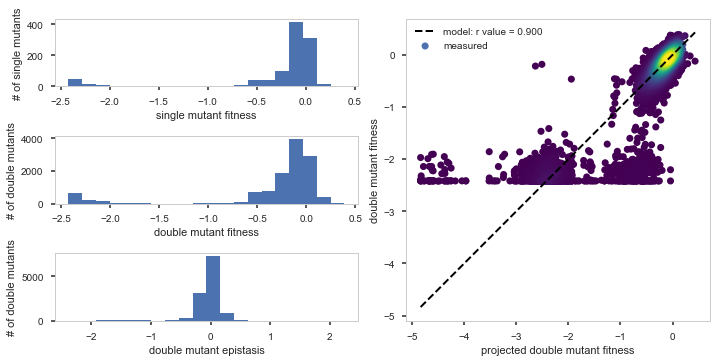

In [68]:
plot_double_fitness_nogrid(gfp, outfile='../../final_formatted_submission/raw_components/sf2/gfp_fit.png')

  index        Ws
0   T1A  1.019242
1   T1C  1.041061
2   T1D  0.965748
3   T1E  1.050524
4   T1F  1.031841 mut.i
T1A    1.019242
T1C    1.041061
T1D    0.965748
T1E    1.050524
T1F    1.031841
Name: Ws, dtype: float64


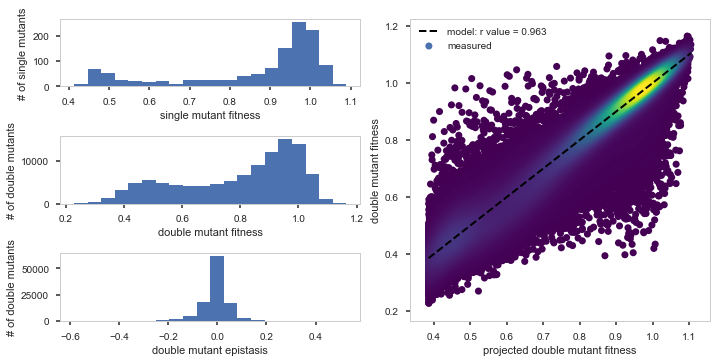

In [66]:
plot_double_fitness_nogrid(fosjun, fit='double.mut.fit', proj='fit.proj.thermo', epi='mepi_thermo',
                    fits='Ws', outfile='../../final_formatted_submission/raw_components/sf2/fosjun_fit.png')



   index      lnWs
0  Q228A  0.417347
1  Q228C  0.024107
2  Q228D -0.093580
3  Q228E -0.049629
4  Q228F  0.480461 mut.i
Q228A    0.417347
Q228C    0.024107
Q228D   -0.093580
Q228E   -0.049629
Q228F    0.480461
Name: lnWs, dtype: float64


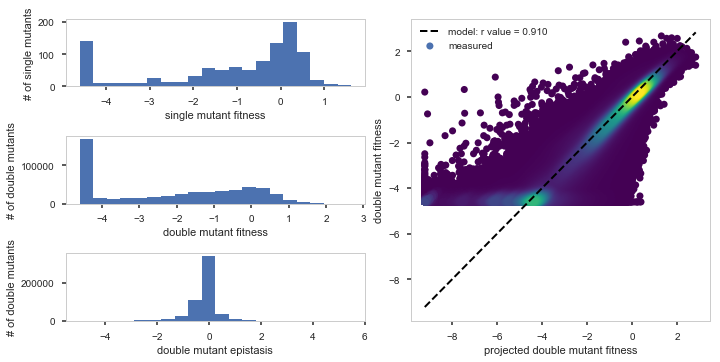

In [67]:
plot_double_fitness_nogrid(gb1, outfile='../../final_formatted_submission/raw_components/sf2/gb1_fit.png')

  index      lnWs
0  D10E  0.161260
1  L30M -0.130315
2  G16A -0.515532
3  V11H  0.342542
4  R27P  0.137432 mut.i
D10E    0.161260
L30M   -0.130315
G16A   -0.515532
V11H    0.342542
R27P    0.137432
Name: lnWs, dtype: float64
      index      lnWs
0  ['G169W' -1.302243
1  ['G169V' -1.351846
2  ['G169A'  0.018809
3  ['G169C' -0.186921
4  ['G169Q' -1.944247 mut.i
['G169W'   -1.302243
['G169V'   -1.351846
['G169A'    0.018809
['G169C'   -0.186921
['G169Q'   -1.944247
Name: lnWs, dtype: float64
  index      lnWs
0   A7U -1.096910
1   A7G -0.301030
2   A7C -1.301030
3   A8U -0.301030
4   A8G -0.142668 mut.i
A7U   -1.096910
A7G   -0.301030
A7C   -1.301030
A8U   -0.301030
A8G   -0.142668
Name: lnWs, dtype: float64


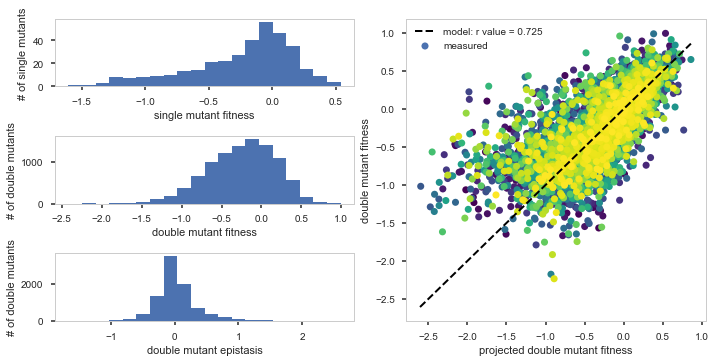

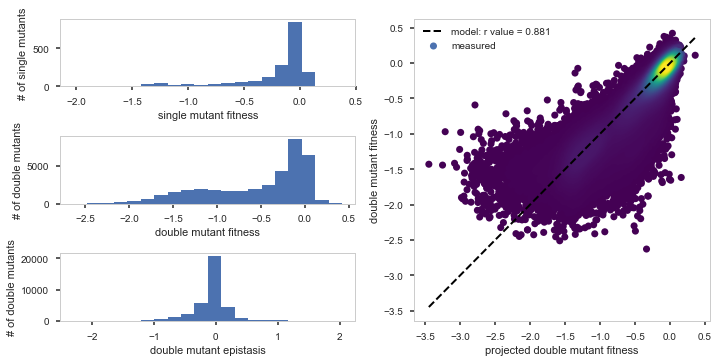

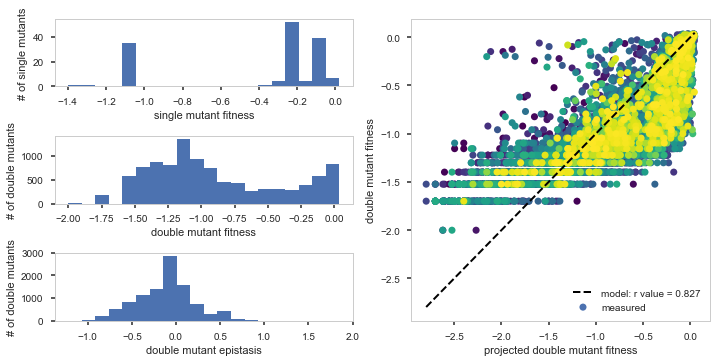

In [59]:
plot_double_fitness_nogrid(ww, outfile='../../final_formatted_submission/raw_components/sf2/ww_fit.png')

#plot_double_fitness(gb1, outfile='./results/plots/fitness_distributions/gb1_fit.png')
plot_double_fitness_nogrid(rrm, outfile='../../final_formatted_submission/raw_components/sf2/rrm_fit2.png')
#plot_double_fitness_nogrid(fosjun, fit='double.mut.fit', proj='fit.proj.thermo', epi='mepi_thermo',
#                    fits='Ws', outfile='../../final_formatted_submission/raw_components/sf2/fosjun_fit.png')#
plot_double_fitness_nogrid(twister, outfile='../../final_formatted_submission/raw_components/sf2/twister_fit2.png')

# Data completeness

## Visualizing the completeness of each mutant scan, and local abscences in measurement coverage

Plotting just a few mutant coverage maps as examples- uncomment the others to create plots for other mutation scans:

In [44]:
from DMS_to_3D5 import plot_mutant_coverage_nogrid

In [31]:
!mkdir ../../final_formatted_submission/raw_components/sf1

In [51]:
ww.loc[:, 'positions'] = ww['positions'].apply( lambda x: (x[0]+160, x[1]+160) )

In [52]:
ww.head()

,mut,positions,mut.aminos,wt.aminos,W,lnW,lnWs,lnW.proj,lnW.cap,epi,slope,rsquared,fitness,i,A_i,mut.i,j,A_j,mut.j,LR
0,"[D10E, G16S]","(170, 176)","('E', 'S')","('D', 'G')",0.523249,-0.281291,"[0.16126027244951294, -0.4576425366761136]",-0.296382,-0.296382,0.015091,-0.126323,0.061684,0.523249,10,D,D10E,16,G,G16S,True
1,"[L30M, Q40L]","(190, 200)","('M', 'L')","('L', 'Q')",0.312773,-0.504771,"[-0.1303146746052101, -0.26691092001628736]",-0.397226,-0.397226,-0.107546,-0.868708,0.436073,0.312773,30,L,L30M,40,Q,Q40L,True
2,"[L30M, Q40H]","(190, 200)","('M', 'H')","('L', 'Q')",0.850382,-0.070386,"[-0.1303146746052101, 0.1454639767587164]",0.015149,0.015149,-0.085535,0.574290,0.919589,0.850382,30,L,L30M,40,Q,Q40H,True
3,"[L30M, Q40K]","(190, 200)","('M', 'K')","('L', 'Q')",0.857740,-0.066644,"[-0.1303146746052101, -0.2488752913423343]",-0.379190,-0.379190,0.312546,0.586719,0.482751,0.857740,30,L,L30M,40,Q,Q40K,True
4,"[L30M, Q40D]","(190, 200)","('M', 'D')","('L', 'Q')",1.125002,0.051153,"[-0.1303146746052101, -0.18338514294780048]",-0.313700,-0.313700,0.364853,0.978034,0.355178,1.125002,30,L,L30M,40,Q,Q40D,True


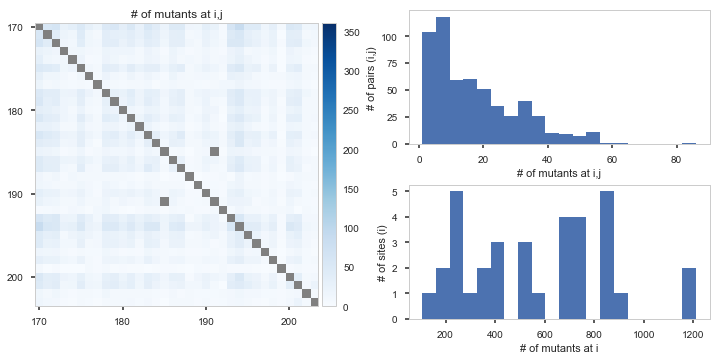

In [53]:
#plot_mutant_coverage_nogrid(gb1[gb1['Input Count'].gt(20)], np.arange(228, 282+1),
#    outfile='../../final_formatted_submission/raw_components/sf1/gb1_inputGT20_coverage.png')
#
#
## many GB1 measurements likely obscure true epistasis- because they hit the measurement floor
#plot_mutant_coverage_nogrid(gb1[gb1['Input Count'].gt(20)
#                         & gb1['lnWs'].apply(lambda x: x[0] > -4.5 and x[1] > -4.5)
#                         & gb1['lnW'].gt(-4.5)], np.arange(228, 282+1),
#    outfile='../../final_formatted_submission/raw_components/sf1/gb1_notMeasurementFloor_coverage.png')

plot_mutant_coverage_nogrid(ww, np.arange(170, 203+1),
    outfile='../../final_formatted_submission/raw_components/sf1/ww_coverage.png')
#plot_mutant_coverage_nogrid(rrm, np.arange(126, 199+1),
#    outfile='../../final_formatted_submission/raw_components/sf1/rrm_coverage.png')
#plot_mutant_coverage_nogrid(twister, np.arange(7, 54+1), [0, 9],
#    outfile='../../final_formatted_submission/raw_components/sf1/twister_coverage.png')
#plot_mutant_coverage_nogrid(fosjun, np.arange(1, 64+1),
#    outfile='../../final_formatted_submission/raw_components/sf1/fosjun_coverage.png')
#plot_mutant_coverage_nogrid(gfp, np.arange(1, 235+1), n = 25,
#    outfile='../../final_formatted_submission/raw_components/sf1/gfp_coverage.png')

# Predicting 3D contacts from experimental epistasis

## Contact prediction method-- the i,j pairs with largest measured epistasis in any double mutant

The method for predicting contacts is very simple:
1. sort all double mutants by measured epistasis
2. keep only the top most epistatic mutant at each i,j site

The highest ranking ('top') i,j sites are therefore those with the strongest epistasis at any mutant measured at that site.  
These are the pairs we suspect are most likely in contact.

In [4]:
def most_epistatic_pairs(epi_table, epi='epi', sign='positive'):
    '''finds the double mutant with highest epistasis at each i-j pair'''

    top_pairs = epi_table.sort_values(epi, ascending=(sign != 'positive'))
    top_pairs = top_pairs.drop_duplicates('positions', keep='first')
    
    # record-keeping detail: how many mutants were measured at each site?
    num_pairs = epi_table.groupby('positions')['mut'].apply(len)
    num_pairs = num_pairs.reset_index().rename(columns = {'mut': 'num.muts'})
    top_pairs = pd.merge(top_pairs, num_pairs, on='positions')
    
    return(top_pairs)

### We found top pairs according to positive epistasis to correspond most strongly to 3D contacts:

In [40]:
gfp.loc[:, 'epi'] = gfp['lnW'] - gfp['lnW.cap']

In [41]:
gfp_top = most_epistatic_pairs(gfp)

In [9]:
gb1_top = most_epistatic_pairs(gb1[gb1['Input Count'].gt(20)])
ww_top = most_epistatic_pairs(ww)
rrm_top = most_epistatic_pairs(rrm)
fosjun_top = most_epistatic_pairs(fosjun, 'mepi_thermo')
twister_top = most_epistatic_pairs(twister)
gfp_top = most_epistatic_pairs(gfp)

KeyError: 'epi'

### Top pairs according to absolute and negative epistasis- not used for main results:

In [194]:
rrm.loc[:, 'epi.abs'] = np.abs(rrm['epi'])

In [198]:
rrm_top = most_epistatic_pairs(rrm)
rrm_neg = most_epistatic_pairs(rrm, sign='negative')
rrm_abs = most_epistatic_pairs(rrm, epi='epi.abs')

In [137]:
rrm_top2.sort_values('epi', ascending=False).head()['epi']

0    2.035096
1    1.692701
2    1.672102
3    1.657734
4    1.647749
Name: epi, dtype: float64

In [151]:
rrm.sort_values('epi').tail()['epi']

18579    1.892508
24773    1.920769
33622    1.964109
8800     2.035096
16316    2.185958
Name: epi, dtype: float64

In [165]:
max(rrm['Epistasis_score'])

1.55260043

In [166]:
max(rrm['Capped_Epistasis_score'])

0.791180195999999

In [192]:
max(rrm[rrm['positions'].apply(lambda x: np.abs( x[1] - x[0] ) > 5)]['e1'])

1.6927015235726068

In [191]:
rrm.loc[:, 'e1'] = rrm['lnW'] - rrm['lnW.cap']

In [185]:
rrm[rrm['positions'].apply(lambda x: x== (142, 146))]

,mut,positions,mut.aminos,wt.aminos,W,lnW,lnWs,WaWb,WaWb.cap,Capped_Epistasis_score,...,lnW.proj,lnW.cap,epi,i,A_i,mut.i,j,A_j,mut.j,e1
5012,"[L142S, F146Y]","(142, 146)","('S', 'Y')","('L', 'F')",0.086236,-1.064312,"[-1.0308340932696822, -0.16124290824235835]",0.064257,0.064257,0.021979,...,-1.192077,-1.192077,0.127765,142,L,L142S,146,F,F146Y,0.127765
5013,"[L142V, F146S]","(142, 146)","('V', 'S')","('L', 'F')",0.104528,-0.980766,"[-0.07614008083854824, -0.16439525040633537]",0.574731,0.574731,-0.470203,...,-0.240535,-0.240535,-0.740230,142,L,L142V,146,F,F146S,-0.740230
5014,"[L142M, F146S]","(142, 146)","('M', 'S')","('L', 'F')",0.106464,-0.972797,"[-0.015576321233586538, -0.16439525040633537]",0.660737,0.660737,-0.554273,...,-0.179972,-0.179972,-0.792825,142,L,L142M,146,F,F146S,-0.792825
5016,"[L142V, F146Y]","(142, 146)","('V', 'Y')","('L', 'F')",0.052264,-1.281796,"[-0.07614008083854824, -0.16124290824235835]",0.578918,0.578918,-0.526654,...,-0.237383,-0.237383,-1.044413,142,L,L142V,146,F,F146Y,-1.044413
5017,"[L142V, F146I]","(142, 146)","('V', 'I')","('L', 'F')",0.118363,-0.926784,"[-0.07614008083854824, -0.025485240039940307]",0.791361,0.791361,-0.672998,...,-0.101625,-0.101625,-0.825159,142,L,L142V,146,F,F146I,-0.825159
5018,"[L142M, F146C]","(142, 146)","('M', 'C')","('L', 'F')",1.009970,0.004309,"[-0.015576321233586538, -0.02340971673166458]",0.914143,0.914143,0.085857,...,-0.038986,-0.038986,0.043295,142,L,L142M,146,F,F146C,0.043295
5019,"[L142M, F146I]","(142, 146)","('M', 'I')","('L', 'F')",0.692836,-0.159370,"[-0.015576321233586538, -0.025485240039940307]",0.909784,0.909784,-0.216949,...,-0.041062,-0.041062,-0.118308,142,L,L142M,146,F,F146I,-0.118308
5020,"[L142W, F146Y]","(142, 146)","('W', 'Y')","('L', 'F')",0.038327,-1.416494,"[-1.2951729315760105, -0.16124290824235835]",0.034961,0.034961,0.003366,...,-1.456416,-1.456416,0.039922,142,L,L142W,146,F,F146Y,0.039922
5021,"[L142S, F146S]","(142, 146)","('S', 'S')","('L', 'F')",0.097856,-1.009411,"[-1.0308340932696822, -0.16439525040633537]",0.063793,0.063793,0.034064,...,-1.195229,-1.195229,0.185819,142,L,L142S,146,F,F146S,0.185819
5022,"[L142V, F146V]","(142, 146)","('V', 'V')","('L', 'F')",0.183970,-0.735253,"[-0.07614008083854824, -0.06344401036330267]",0.725130,0.725130,-0.541160,...,-0.139584,-0.139584,-0.595669,142,L,L142V,146,F,F146V,-0.595669


In [184]:
rrm.sort_values('e1').tail()

,mut,positions,mut.aminos,wt.aminos,W,lnW,lnWs,WaWb,WaWb.cap,Capped_Epistasis_score,...,lnW.proj,lnW.cap,epi,i,A_i,mut.i,j,A_j,mut.j,e1
32454,"[L133R, G150R]","(133, 150)","('R', 'R')","('L', 'G')",0.104528,-0.980766,"[-1.632513418862111, -1.3605475384394476]",0.001016,0.002352,0.103512,...,-2.993061,-2.628515,1.647749,133,L,L133R,150,G,G150R,1.647749
33736,"[K131T, G150P]","(131, 150)","('T', 'P')","('K', 'G')",0.106959,-0.970781,"[-1.2255140126162913, -1.9885909984834156]",0.000611,0.002352,0.106349,...,-3.214105,-2.628515,1.657734,131,K,K131T,150,G,G150P,1.657734
10929,"[S154P, F173S]","(154, 173)","('P', 'S')","('S', 'F')",0.110557,-0.956413,"[-1.307578915635318, -1.4132775450147799]",0.001902,0.002352,0.108656,...,-2.720856,-2.628515,1.672102,154,S,S154P,173,F,F173S,1.672102
3882,"[I152N, F173S]","(152, 173)","('N', 'S')","('I', 'F')",0.115928,-0.935814,"[-1.3299570599554158, -1.4132775450147799]",0.001806,0.002352,0.114121,...,-2.743235,-2.628515,1.692702,152,I,I152N,173,F,F173S,1.692702
8800,"[G169W, V171D]","(169, 171)","('W', 'D')","('G', 'V')",0.255024,-0.593419,"[-1.3022428219731825, -1.4859613873926891]",0.001629,0.002352,0.253395,...,-2.788204,-2.628515,2.035096,169,G,G169W,171,V,V171D,2.035096


In [181]:
np.max(np.log10(rrm['W']) - np.log10(rrm['WaWb.cap']))

2.0350958214663843

In [163]:

rrm = rrm[~rrm['mut'].apply(lambda x: '*' in str(x))]

In [175]:
rrm_top[rrm_top['LR']].head()

,mut,positions,mut.aminos,wt.aminos,lnW,lnWs,lnW.proj,lnW.cap,epi,Enrichment,...,mut.j,LR,epi.abs,dist.1cvj,dist.2k8g,dist.4f02,dist.4f25,dist.4f26,dist.any_struct,num.muts
1,"[['I152N', 'F173S']]","(152, 173)","('N', 'S')","('I', 'F')",-0.935814,"[-1.3299570599554158, -1.4132775450147799]",-2.743235,-2.628515,1.692701,0.115928,...,'F173S'],True,2.628515,4.437470,4.316475,4.754406,5.093026,5.024795,4.316475,41
2,"[['S154P', 'F173S']]","(154, 173)","('P', 'S')","('S', 'F')",-0.956413,"[-1.307578915635318, -1.4132775450147799]",-2.720856,-2.628515,1.672102,0.110557,...,'F173S'],True,2.628515,6.679422,6.693204,6.718460,6.959817,6.916068,6.679422,34
3,"[['K131T', 'G150P']]","(131, 150)","('T', 'P')","('K', 'G')",-0.970781,"[-1.2255140126162913, -1.9885909984834156]",-3.214105,-2.628515,1.657734,0.106959,...,'G150P'],True,2.628515,17.446061,17.067492,17.432324,17.395286,17.056316,17.056316,36
4,"[['L133R', 'G150R']]","(133, 150)","('R', 'R')","('L', 'G')",-0.980766,"[-1.632513418862111, -1.3605475384394476]",-2.993061,-2.628515,1.647749,0.104528,...,'G150R'],True,2.628515,16.154129,15.122762,15.783828,16.379444,16.160808,15.122762,29
5,"[['N127Y', 'G150R']]","(127, 150)","('Y', 'R')","('N', 'G')",-1.000071,"[-1.3729555685397479, -1.3605475384394476]",-2.733503,-2.628515,1.628444,0.099984,...,'G150R'],True,2.628515,11.357216,11.274156,11.349069,11.030101,10.807994,10.807994,40


In [154]:
max(rrm['Capped_Epistasis_score'])

0.791180195999999

In [153]:
rrm.keys()

Index(['mut', 'positions', 'mut.aminos', 'wt.aminos', 'W', 'lnW', 'lnWs',
       'WaWb', 'WaWb.cap', 'Capped_Epistasis_score', 'Enrichment',
       'Epistasis_score', 'lnW.proj', 'lnW.cap', 'epi', 'i', 'A_i', 'mut.i',
       'j', 'A_j', 'mut.j'],
      dtype='object')

In [152]:
rrm.sort_values('epi').tail()['epi'] #head()

18579    1.892508
24773    1.920769
33622    1.964109
8800     2.035096
16316    2.185958
Name: epi, dtype: float64

In [144]:
rrm.keys()

Index(['mut', 'positions', 'mut.aminos', 'wt.aminos', 'lnW', 'lnWs',
       'lnW.proj', 'lnW.cap', 'epi', 'Enrichment', 'i', 'A_i', 'mut.i', 'j',
       'A_j', 'mut.j', 'LR', 'epi.abs', 'dist.1cvj', 'dist.2k8g', 'dist.4f02',
       'dist.4f25', 'dist.4f26', 'dist.any_struct'],
      dtype='object')

In [82]:
for dms in [gb1, ww, twister, gfp]:
    dms.loc[:, 'epi.abs'] = dms['epi'].apply(np.abs)

rrm.loc[:, 'epi.abs'] = rrm['lnW.cap'].apply(np.abs)
fosjun.loc[:, 'epi.abs'] = fosjun['mepi_thermo'].apply(np.abs)


gb1_abs = most_epistatic_pairs(gb1[gb1['Input Count'].gt(20)], epi='epi.abs')
ww_abs = most_epistatic_pairs(ww, epi='epi.abs')
rrm_abs = most_epistatic_pairs(rrm, epi='epi.abs')
fosjun_abs = most_epistatic_pairs(fosjun, epi='epi.abs')
twister_abs = most_epistatic_pairs(twister, epi='epi.abs')
gfp_abs = most_epistatic_pairs(gfp, epi='epi.abs')

gb1_neg = most_epistatic_pairs(gb1[gb1['Input Count'].gt(20)], sign='negative')
ww_neg = most_epistatic_pairs(ww, sign='negative')
rrm_neg = most_epistatic_pairs(rrm, sign='negative')
fosjun_neg = most_epistatic_pairs(fosjun, epi='mepi_thermo', sign='negative')
twister_neg = most_epistatic_pairs(twister, sign='negative')
gfp_neg = most_epistatic_pairs(gfp, sign='negative')

## Top epistasis pair distribution

In [69]:
!mkdir ../../final_formatted_submission/raw_components/sf3

In [142]:
rrm_top.head()

,mut,positions,mut.aminos,wt.aminos,lnW,lnWs,lnW.proj,lnW.cap,epi,Enrichment,...,mut.j,LR,epi.abs,dist.1cvj,dist.2k8g,dist.4f02,dist.4f25,dist.4f26,dist.any_struct,num.muts
0,"[['G169W', 'V171D']]","(169, 171)","('W', 'D')","('G', 'V')",-0.593419,"[-1.3022428219731825, -1.4859613873926891]",-2.788204,-2.628515,2.035096,0.255024,...,'V171D'],False,2.628515,4.263080,4.297741,4.308386,0.497016,4.322865,0.497016,28
1,"[['I152N', 'F173S']]","(152, 173)","('N', 'S')","('I', 'F')",-0.935814,"[-1.3299570599554158, -1.4132775450147799]",-2.743235,-2.628515,1.692701,0.115928,...,'F173S'],True,2.628515,4.437470,4.316475,4.754406,5.093026,5.024795,4.316475,41
2,"[['S154P', 'F173S']]","(154, 173)","('P', 'S')","('S', 'F')",-0.956413,"[-1.307578915635318, -1.4132775450147799]",-2.720856,-2.628515,1.672102,0.110557,...,'F173S'],True,2.628515,6.679422,6.693204,6.718460,6.959817,6.916068,6.679422,34
3,"[['K131T', 'G150P']]","(131, 150)","('T', 'P')","('K', 'G')",-0.970781,"[-1.2255140126162913, -1.9885909984834156]",-3.214105,-2.628515,1.657734,0.106959,...,'G150P'],True,2.628515,17.446061,17.067492,17.432324,17.395286,17.056316,17.056316,36
4,"[['L133R', 'G150R']]","(133, 150)","('R', 'R')","('L', 'G')",-0.980766,"[-1.632513418862111, -1.3605475384394476]",-2.993061,-2.628515,1.647749,0.104528,...,'G150R'],True,2.628515,16.154129,15.122762,15.783828,16.379444,16.160808,15.122762,29


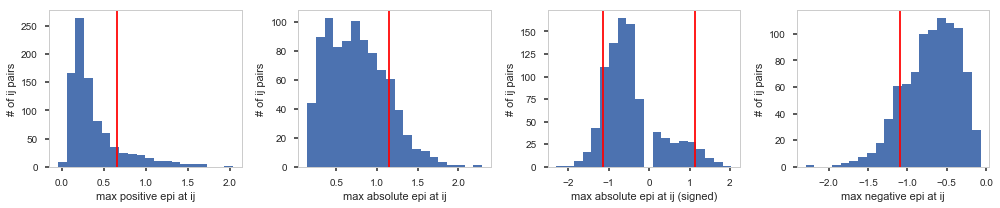

In [201]:
# for each dataset, iterate over the top pairs by positive, absolute, and negative epi
epi_pairs = [
    (gb1_top, gb1_abs, gb1_abs, gb1_neg),
    (ww_top, ww_abs, ww_abs, ww_neg),
    (rrm_top, rrm_abs, rrm_abs, rrm_neg),
    (fosjun_top, fosjun_abs, fosjun_abs, fosjun_neg),
    (twister_top, twister_abs, twister_abs, twister_neg),
    (gfp_top, gfp_abs, gfp_abs, gfp_neg)
]

Ls = [56, 37, 75, 32, 48, 236]
es = ['epi', 'epi.abs', 'epi', 'epi']
rrm_es = ['epi', 'epi.abs',
          'epi', 'epi']
fosjun_es = ['mepi_thermo', 'epi.abs',
             'mepi_thermo', 'mepi_thermo']

list_es = [es, es, rrm_es, fosjun_es, es, es]

ts = ['max positive epi at ij', 'max absolute epi at ij',
     'max absolute epi at ij (signed)', 'max negative epi at ij']

flder = '../../V3_submission/Instructions_from_NG_forms/raw_components/sf3/'
outs = ['gb1', 'ww', 'rrm', 'fosjun', 'twister', 'gfp']

for v, out, L, Es in zip(epi_pairs, outs, Ls, list_es):
    if out != 'rrm':
        continue
    
    fig, axs = plt.subplots(1, 4)
    fig.set_size_inches(14, 3)
    for x, ax, t, e in zip(v, axs, ts, Es):
        ax.hist(x[e].dropna(), bins=20);
        ax.set_xlabel(t)
        ax.set_ylabel('# of ij pairs')
        ax.axvline(x[x['LR']][e].iloc[L-1], color='red')
        ax.grid(False)
        ax.tick_params(direction='out', length=4, width=1.5, axis='y')
        ax.tick_params(direction='out', length=4, width=1.5, axis='x')
        if 'signed' in t:
            ax.axvline(-x[x['LR']][e].iloc[L-1], color='red')
    fig.tight_layout()
    
    fig.savefig(flder + out + '_max_epi_dists--w_cutoff2.png', dpi=300)

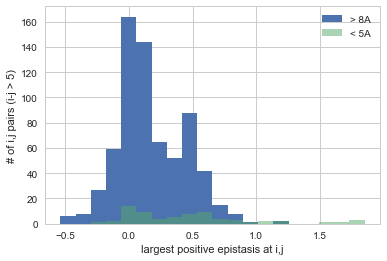

In [23]:
x = twister_top[twister_top['LR']]
e = 'epi'

fig, ax = plt.subplots(1)
bins = np.histogram(x[e], bins=20)
bins = ax.hist(x[x['dist.any_struct'].gt(8)][e], bins=bins[1])
ax.hist(x[x['dist.any_struct'].lt(5)][e], bins=bins[1], alpha=0.5)
ax.legend(['> 8A', '< 5A'])
ax.set_xlabel('largest positive epistasis at i,j')
ax.set_ylabel('# of i,j pairs (i-j > 5)')
fig.savefig('../twister--max_epi_pair--contact_vs_8Anoncontact.svg')

## Epistasis maps

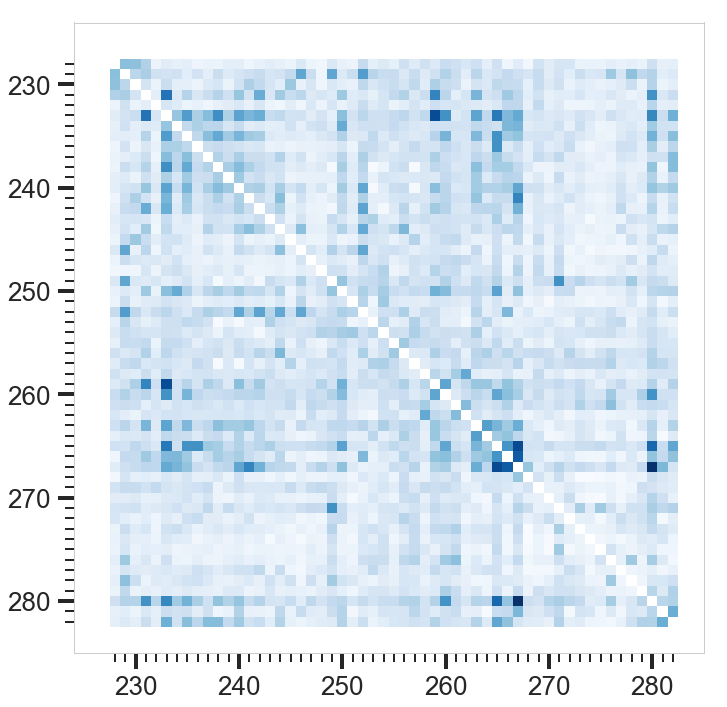

In [158]:
fig, ax, hmap = epi_map(gb1_top, [226, 282], tixm=(228, 283), tixM=(230, 290))
ax.tick_params(width=4, length=16, which='major')
ax.tick_params(width=2, length=9, which='minor')
fig.set_size_inches(10, 10)
fig.tight_layout()

plt.grid(True, which='major')
fig.savefig('../figures/Figure1_top_epi_vals_10grid-b10.svg')

plt.grid(True, which='minor')
fig.savefig('../figures/Figure1_gb1_top_epi_vals_full_grid-b10.svg')

plt.grid(False, which='major')
plt.grid(False, which='minor')
fig.savefig('../figures/Figure1_gb1_top_epi_vals_NOgrid-b10.svg')

## Comparing top epistasis pairs to 3D distances

In [6]:
from DMS_to_3D6 import compare_contacts_verbose

In [7]:
print('yo')

yo


In [12]:
rrm_top.head()

,mut,positions,mut.aminos,wt.aminos,W,lnW,lnWs,WaWb,WaWb.cap,Capped_Epistasis_score,...,A_j,mut.j,LR,dist.1cvj,dist.2k8g,dist.4f02,dist.4f25,dist.4f26,dist.any_struct,num.muts
0,"[G169W, V171D]","(169, 171)","('W', 'D')","('G', 'V')",0.255024,-0.593419,"[-1.3022428219731825, -1.4859613873926891]",0.001629,0.002352,0.253395,...,V,V171D,False,4.263080,4.297741,4.308386,0.497016,4.322865,0.497016,28
1,"[I152N, F173S]","(152, 173)","('N', 'S')","('I', 'F')",0.115928,-0.935814,"[-1.3299570599554158, -1.4132775450147799]",0.001806,0.002352,0.114121,...,F,F173S,True,4.437470,4.316475,4.754406,5.093026,5.024795,4.316475,41
2,"[S154P, F173S]","(154, 173)","('P', 'S')","('S', 'F')",0.110557,-0.956413,"[-1.307578915635318, -1.4132775450147799]",0.001902,0.002352,0.108656,...,F,F173S,True,6.679422,6.693204,6.718460,6.959817,6.916068,6.679422,34
3,"[K131T, G150P]","(131, 150)","('T', 'P')","('K', 'G')",0.106959,-0.970781,"[-1.2255140126162913, -1.9885909984834156]",0.000611,0.002352,0.106349,...,G,G150P,True,17.446061,17.067492,17.432324,17.395286,17.056316,17.056316,36
4,"[L133R, G150R]","(133, 150)","('R', 'R')","('L', 'G')",0.104528,-0.980766,"[-1.632513418862111, -1.3605475384394476]",0.001016,0.002352,0.103512,...,G,G150R,True,16.154129,15.122762,15.783828,16.379444,16.160808,15.122762,29


In [19]:
fosjun_xtals.head()

,positions,../../../../Analysis/submission/additional_data/fosjun_docking/experimental_structure/1FOS_fosjun.pdb,min_overall
0,"(1, 2)",1.327356,1.327356
1,"(1, 3)",2.926201,2.926201
2,"(1, 4)",3.072789,3.072789
3,"(1, 5)",2.722652,2.722652
4,"(1, 6)",4.499786,4.499786


In [22]:
gfp_xtals.head()

,positions,1ema,min_overall
0,"(2, 3)",1.326584,1.326584
1,"(2, 4)",3.887562,3.887562
2,"(2, 5)",3.932254,3.932254
3,"(2, 6)",4.208897,4.208897
4,"(2, 7)",7.004170,7.004170


In [20]:
for dx in [gb1_xtals, ww_xtals, rrm_xtals, twister_xtals, gfp_xtals]:
    print(dx.head())
    dx.loc[:, 'positions'] = dx.apply(lambda x: (x['level_0'], x['level_1']), axis=1)

   level_0  level_1  1gb1       1igd  1pga  1pgb  2gb1       2igd      2igh  \
0      222      223   NaN   1.306831   NaN   NaN   NaN   1.324277  1.310057   
1      222      224   NaN   3.977537   NaN   NaN   NaN   4.019843  3.773608   
2      222      225   NaN   4.661875   NaN   NaN   NaN   3.938543  6.956046   
3      222      226   NaN   7.836708   NaN   NaN   NaN   7.047565  9.156517   
4      222      227   NaN  11.176547   NaN   NaN   NaN  10.390440  6.840312   

   2lgi  2n7j  3gb1       3mp9  min_overall   positions  
0   NaN   NaN   NaN   1.338371     1.306831  (222, 223)  
1   NaN   NaN   NaN   3.041623     3.041623  (222, 224)  
2   NaN   NaN   NaN   6.427750     3.938543  (222, 225)  
3   NaN   NaN   NaN   9.907017     7.047565  (222, 226)  
4   NaN   NaN   NaN  12.000982     6.840312  (222, 227)  
   level_0  level_1  1jmq  1k5r  2lax  2lay  2ltw      4rex  min_overall  \
0        1        2   NaN   NaN   NaN   NaN   NaN  1.320678     1.320678   
1        1        3   NaN

KeyError: ('level_0', 'occurred at index 0')

In [15]:
gb1_xtals.head()

,level_0,level_1,1gb1,1igd,1pga,1pgb,2gb1,2igd,2igh,2lgi,2n7j,3gb1,3mp9,min_overall
0,222,223,NaN,1.306831,NaN,NaN,NaN,1.324277,1.310057,NaN,NaN,NaN,1.338371,1.306831
1,222,224,NaN,3.977537,NaN,NaN,NaN,4.019843,3.773608,NaN,NaN,NaN,3.041623,3.041623
2,222,225,NaN,4.661875,NaN,NaN,NaN,3.938543,6.956046,NaN,NaN,NaN,6.427750,3.938543
3,222,226,NaN,7.836708,NaN,NaN,NaN,7.047565,9.156517,NaN,NaN,NaN,9.907017,7.047565
4,222,227,NaN,11.176547,NaN,NaN,NaN,10.390440,6.840312,NaN,NaN,NaN,12.000982,6.840312


In [14]:
rrm_xtals.head()

,level_0,level_1,1cvj,2k8g,4f02,4f25,4f26,min_overall
0,37,38,NaN,NaN,1.333339,NaN,NaN,1.333339
1,37,39,NaN,NaN,3.799286,NaN,NaN,3.799286
2,37,40,NaN,NaN,6.984980,NaN,NaN,6.984980
3,37,41,NaN,NaN,9.942324,NaN,NaN,9.942324
4,37,42,NaN,NaN,12.891863,NaN,NaN,12.891863


12 570 56 38


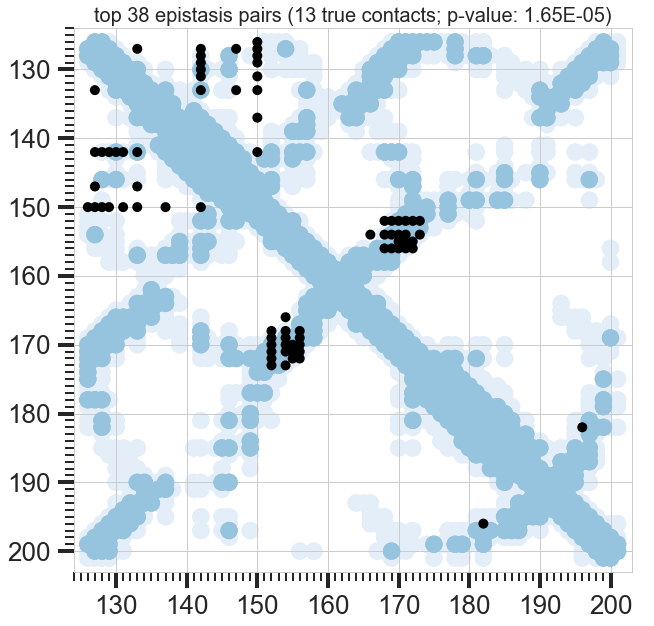

In [24]:
compare_contacts_verbose(
    rrm_xtals.reset_index(), rrm_top[rrm_top['LR']], rrm[rrm['LR']], 'min_overall', 'dist.any_struct', 'rrm',
    [38], (126, 201), (130, 210), (120, 201))

0 8081 182 75


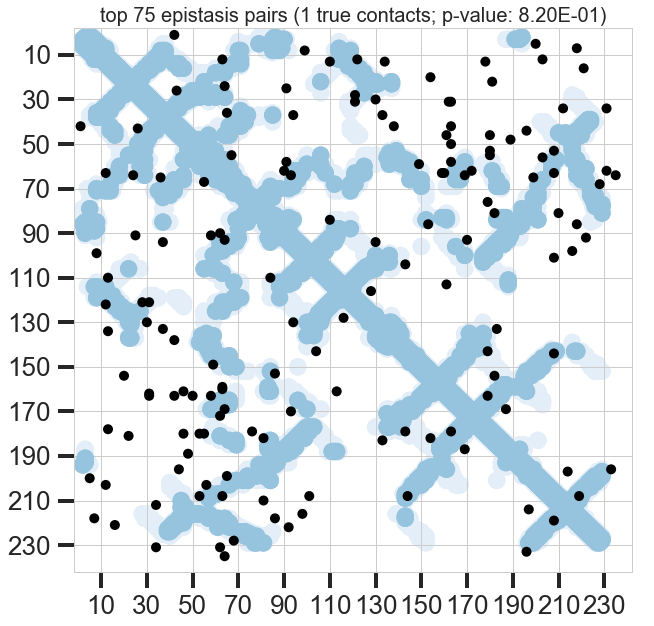

In [43]:
#!mkdir ../supplementary_figures/epi_contacts
#!mkdir ../supplementary_figures/epi_contacts/gb1
#!mkdir ../supplementary_figures/epi_contacts/ww
#!mkdir ../supplementary_figures/epi_contacts/rrm
#!mkdir ../supplementary_figures/epi_contacts/fosjun
#!mkdir ../supplementary_figures/epi_contacts/twister
#!mkdir ../supplementary_figures/epi_contacts/gfp

#compare_contacts_verbose(
#    gb1_xtals, gb1_top[gb1_top['LR']], gb1[gb1['LR']], 'min_overall', 'dist.any_struct', 'gb1',
#    [10], (226, 283), (230, 290), (226, 283))
#compare_contacts_verbose(
#    ww_xtals, ww_top[ww_top['LR']], ww[ww['LR']], 'min_overall', 'dist.any_struct', 'ww',
#    [5], (10, 43), (10, 50), (10, 43), oL=160, s = 650)
#compare_contacts(
#    rrm_xtals, rrm_top, rrm, 'min_overall', 'dist.any_struct', 'rrm',
#    [10, 15, 20, 25, 30, 40, 50, 60], (126, 201), (130, 210), (120, 201))
#compare_contacts_verbose(
#    fosjun_xtals, fosjun_top, fosjun, 'min_overall', 'dist.any_struct', 'fosjun',
#    [3], (1, 63), (10, 70), (1, 64))
#compare_contacts_verbose(
#    twister_xtals, twister_top[twister_top['LR']], twister[twister['LR']], 'min_overall', 'dist.any_struct', 'twister',
#    [5], (1, 55), (10, 60), (1, 55))
compare_contacts_verbose(
    gfp_xtals, gfp_top[gfp_top['LR']], gfp[gfp['LR']], 'min_overall', 'dist.any_struct', 'gfp',
    [75], (0, 240), (10, 240), (1, 1), tN=20)


## Secondary structure prediction method

### Extract secondary structure regions from experimental structures for comparison

In [511]:
gb1_ss = merge_ss(gb1_pdbs).set_index('id').loc[np.arange(228, 283)]
gb1_ss.to_csv('../supplementary_tables/secondary_scores_vs_xtal_sec_struct.csv')
print(''.join(gb1_ss['joint']))

#results in:
gb1_betastrands = [(228, 234), (239, 246), (268, 272), (277, 281)]
gb1_helix = (249, 263)

EEEEEEECCCCEEEEEEEECCHHHHHHHHHHHHHHHCCCCEEEEECCCCEEEEEC


In [515]:
ww_ss = merge_ss(ww_pdbs).set_index('id').loc[np.arange(10, 45)]
ww_ss.to_csv('../supplementary_tables/ww_secondary_scores_vs_xtal_sec_struct.csv')
print(''.join(ww_ss['joint']))

#results in:
ww_betastrands = [(17, 22), (26, 31), (36, 38)]

CCCCCCCEEEEEECCCEEEEEECCCCEEECCCHHH


In [549]:
rrm_ss = merge_ss(rrm_pdbs).set_index('id').loc[np.arange(50, 201)]
rrm_ss.to_csv('../supplementary_tables/rrm_secondary_scores_vs_xtal_sec_struct.csv')
print(''.join(rrm_ss['joint']))

#results in:
rrm_betastrands = [(64,71), (78,86), (103,113), (127,131), (152,157), (168,172), (187,190), (193,199)]
rrm_helices = [(51,61), (89,96), (119,122), (139,147), (175,181)]


CHHHHHHHHHHHCCEEEEEEEECCCCCCEEEEEEEEECCHHHHHHHHCCCCCCEECCEECEEEECCCCCHHHHCCCCEEEEECCCCCCCHHHHHHHHHCCCCEEEEEECCECCECCCCEEEEECCHHHHHHHCCCCCEEEECCEEEEEEEC


### Visualization

In [6]:
gb1_2ndary = compute_SS(gb1_top, fill=np.nan)
#ww_2ndary = compute_SS(ww_top, fill=np.nan)
#rrm_2ndary = compute_SS(rrm_top, fill=np.nan)

## Comparing predicted secondary structure to experimental

In [91]:
acut = 1.5
bcut = 2

mkdir: ../../final_formatted_submission/raw_components/sf5: File exists


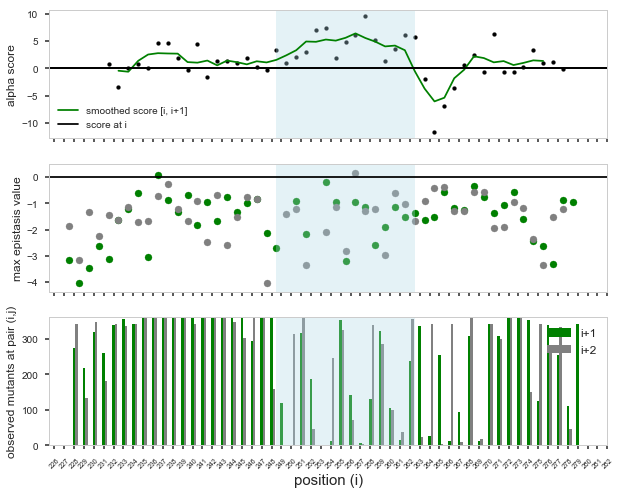

In [96]:
!mkdir ../../final_formatted_submission/raw_components/sf5
gb1_scores = compute_SS(gb1_top, e='epi', l=1, r=1, acut=acut, bcut=bcut,
                   na=4, nb=2)
fig, ax = plot_alpha_pairs(gb1[gb1['lnW'].gt(-4.5) & gb1['lnW.proj'].gt(-4.5)
                              & gb1['lnWs'].apply(lambda x: (x[0] > -4.5) and (x[1] > -4.5))],
                           gb1_scores, np.arange(0, 57)+226, o=0, fs=7)
#ax[0].set_ylim(-11, 14)

for i in [0, 1, 2]:
    rect = patches.Rectangle((gb1_helix[0],-30), gb1_helix[1]-gb1_helix[0], 600, linewidth=1, edgecolor=None, facecolor='lightblue', alpha=0.33)
    ax[i].add_patch(rect)
    ax[i].grid(False)
    ax[i].tick_params(direction='out', length=4, width=1.5, axis='y')
    ax[i].tick_params(direction='out', length=4, width=1.5, axis='x')
fig.savefig('../../final_formatted_submission/raw_components/sf5/gb1_alpha_coverage_and_scores-floor.png', dpi=300)

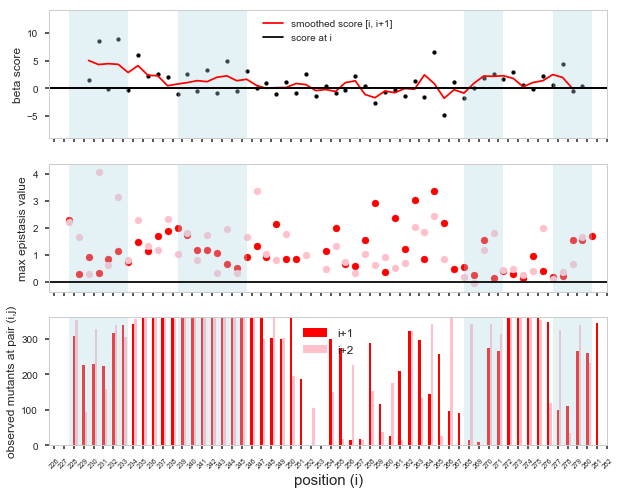

In [95]:

fig, ax = plot_beta_pairs(gb1[gb1['lnW'].gt(-4.5) & gb1['lnW.proj'].gt(-4.5)
                              & gb1['lnWs'].apply(lambda x: (x[0] > -4.5) and (x[1] > -4.5))],
                          gb1_scores, np.arange(0, 57)+226, o=0, fs=7)

for (a,b) in gb1_betastrands:
    for i in [0, 1, 2]:
        rect = patches.Rectangle((a,-10), b-a, 1000, linewidth=1, edgecolor=None, facecolor='lightblue', alpha=0.33)
        ax[i].add_patch(rect)
        ax[i].grid(False)
        ax[i].tick_params(direction='out', length=4, width=1.5, axis='y')
        ax[i].tick_params(direction='out', length=4, width=1.5, axis='x')
ax[0].set_ylim(-9, 14)
        
fig.savefig('../../final_formatted_submission/raw_components/sf5/gb1_beta_coverage_and_scores-floor.png', dpi=300)

In [202]:
rrm_scores = compute_SS(rrm_top, fill=np.nan)

In [104]:
gb1_scores = compute_SS(gb1_top, fill=np.nan)
ww_scores = compute_SS(ww_top, fill=np.nan)
rrm_scores = compute_SS(rrm_top, fill=np.nan)

In [108]:
gb1_ss = merge_ss(gb1_pdbs).set_index('id').loc[np.arange(228, 283)]

In [106]:
ww_ss = merge_ss(ww_pdbs).set_index('id').loc[np.arange(10, 45)]

In [326]:
#rrm_ss = merge_ss(rrm_pdbs).set_index('id').loc[np.arange(50, 201)]
#rrm_ss.to_csv('../../../../Analysis/submission/supplementary_tables/rrm_secondary_scores_vs_xtal_sec_struct.csv')
print(''.join(rrm_ss['joint']))

#results in:
rrm_betastrands = [(64,71), (78,86), (103,113), (127,131), (152,157), (168,172), (187,190), (193,199)]
rrm_helices = [(51,61), (89,96), (119,122), (139,147), (175,181)]


rrm_compare_ss = pd.merge(rrm_ss, rrm_scores.set_index('i'), left_index=True, right_index=True)
rrm_compare_ss.loc[:, 'conservative'] = minimum_ss_unit(list(rrm_compare_ss['sec_struct_3state']))
rrm_compare_ss.loc[:, 'xtal.alpha'] = rrm_compare_ss['conservative'].eq('H')
rrm_compare_ss.loc[:, 'xtal.beta'] = rrm_compare_ss['conservative'].eq('E')
ww_compare_ss = pd.merge(ww_ss, ww_scores.set_index('i'), left_index=True, right_index=True)
#rrm_compare_ss.loc[:, 'conservative'] = lose_stragglers(list(rrm_compare_ss['sec_struct_3state']))
ww_compare_ss.loc[:, 'xtal.alpha'] = ww_compare_ss['joint'].eq('H')
ww_compare_ss.loc[:, 'xtal.beta'] = ww_compare_ss['joint'].eq('E')
gb1_compare_ss = pd.merge(gb1_ss, gb1_scores.set_index('i'), left_index=True, right_index=True)
#gb1_compare_ss.loc[:, 'conservative'] = lose_stragglers(list(rrm_compare_ss['sec_struct_3state']))
gb1_compare_ss.loc[:, 'xtal.alpha'] = gb1_compare_ss['joint'].eq('H')
gb1_compare_ss.loc[:, 'xtal.beta'] = gb1_compare_ss['joint'].eq('E')

CHHHHHHHHHHHCCEEEEEEEECCCCCCEEEEEEEEECCHHHHHHHHHHHCCCEECCEECEEEECCCCCHHHHHCCCEEEEECCCCCCCHHHHHHHHHHHCCEEEEEEEEECCEEEEEEEEEECCHHHHHHHHHHHCEEEECCEEEEEEEC


In [207]:
ss_scores = pd.ExcelFile('../../archive/Supplementary Tables/TableS4_secondary_structure_scores_from_epistasis.xlsx')

In [224]:
test = pd.read_excel('../../archive/Supplementary Tables/TableS4_secondary_structure_scores_from_epistasis.xlsx', sheetname='RRM')

In [225]:
test2 = test.rename(columns = {
    k: test[k].iloc[0]
    for k in test.keys() if 'RRM' not in k
})

In [250]:
test3 = test2.iloc[1:]
test3.loc[:, 'i'] = test3['i'].astype(int)

/Users/nrollins/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [252]:
test4 = test3.set_index('i')

In [251]:
#test2 = test2.rename(columns = {'RRM (amino acids 125 - 200)': 'i'})

In [245]:
np.mean(test3['xtal.alpha'].apply(lambda x: isinstance(x, bool)))

1.0

In [259]:
test4['2k8g'].loc[126]

'C'

In [258]:
rrm_compare_ss['2k8g'].loc[126]

'C'

In [277]:
np.nanmax(test4['beta_smooth'])

54.34793107430325

In [263]:
test4.head()

,1cvj,2k8g,4f02,4f25,4f26,joint,alpha,beta,seq,alpha_smooth,beta_smooth,xtal.alpha,xtal.beta
i,,,,,,,,,,,,,
126,C,C,C,C,C,C,NaN,NaN,G,NaN,NaN,False,False
127,E,E,E,E,E,E,NaN,NaN,N,NaN,NaN,False,True
128,E,E,E,E,E,E,NaN,-5.96667,I,NaN,7.42521,False,True
129,E,E,E,E,E,E,NaN,20.8171,F,NaN,4.45491,False,True
130,E,E,E,E,E,E,17.7493,-11.9073,I,26.4226,-8.42449,False,True


In [264]:
rrm_compare_ss.head()

,sec_struct_3state,2k8g,4f02,4f25,4f26,joint,alpha,beta,seq,alpha_smooth,beta_smooth,conservative,xtal.alpha,xtal.beta
126,C,C,C,C,C,C,NaN,NaN,G,NaN,NaN,C,False,False
127,E,E,E,E,E,E,NaN,NaN,N,NaN,NaN,E,False,True
128,E,E,E,E,E,E,NaN,-9.400280,I,NaN,4.297189,E,False,True
129,E,E,E,E,E,E,NaN,17.994658,F,NaN,6.830436,E,False,True
130,E,E,E,E,E,E,7.945256,-4.333786,I,NaN,6.786820,E,False,True


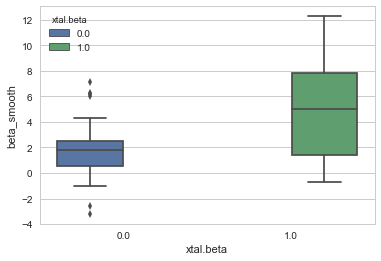

In [268]:
sns.boxplot(x='xtal.beta', y='beta_smooth', hue='xtal.beta', data=rrm_compare_ss[~rrm_compare_ss['beta_smooth'].isnull()])

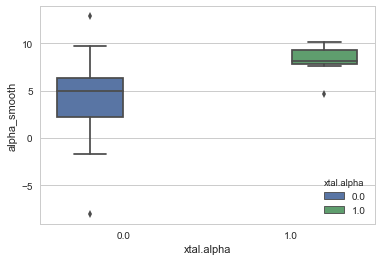

In [267]:
sns.boxplot(x='xtal.alpha', y='alpha_smooth', hue='xtal.alpha', data=rrm_compare_ss[~rrm_compare_ss['alpha_smooth'].isnull()])

In [298]:
len(test4)

72

In [295]:
test4.head()

,1cvj,2k8g,4f02,4f25,4f26,joint,alpha,beta,seq,alpha_smooth,beta_smooth,xtal.alpha,xtal.beta
i,,,,,,,,,,,,,
126,C,C,C,C,C,C,NaN,NaN,G,NaN,NaN,False,False
127,E,E,E,E,E,E,NaN,NaN,N,NaN,NaN,False,True
128,E,E,E,E,E,E,NaN,-5.96667,I,NaN,7.42521,False,True
129,E,E,E,E,E,E,NaN,20.8171,F,NaN,4.45491,False,True
130,E,E,E,E,E,E,17.7493,-11.9073,I,26.4226,-8.42449,False,True


In [297]:
len(rrm_compare_ss)

72

In [302]:
len(list(test4['alpha_smooth']))

72

In [305]:
rrm_compare_ss

,sec_struct_3state,2k8g,4f02,4f25,4f26,joint,alpha,beta,seq,alpha_smooth,beta_smooth,conservative,xtal.alpha,xtal.beta
126,C,C,C,C,C,C,NaN,NaN,G,NaN,NaN,C,False,False
127,E,E,E,E,E,E,NaN,NaN,N,NaN,NaN,E,False,True
128,E,E,E,E,E,E,NaN,-9.400280,I,NaN,4.297189,E,False,True
129,E,E,E,E,E,E,NaN,17.994658,F,NaN,6.830436,E,False,True
130,E,E,E,E,E,E,7.945256,-4.333786,I,NaN,6.786820,E,False,True
131,E,E,E,E,E,E,-7.455279,17.907427,K,6.419967,7.725828,E,False,True
132,C,C,C,C,C,C,7.172806,-2.455771,N,3.952381,4.325055,C,False,False
133,C,C,C,C,C,C,18.017085,11.105882,L,6.307758,6.037851,C,False,False
134,C,C,C,C,C,C,-1.925088,0.969820,H,5.208844,1.761844,C,False,False
135,C,C,C,C,C,C,1.966227,2.553868,P,4.812166,2.484062,C,False,False


In [304]:
np.array(test4['alpha_smooth'])

array([nan, nan, nan, nan, 26.42261476344827, 19.49626843861341,
       12.87414244676111, 13.61780879590886, 5.839069369316292,
       9.484137334639794, 12.25459724797249, 12.58020020976567,
       6.890653195285939, 15.98733861624072, 14.58802179194524,
       13.4656143778336, 20.59912285505707, 21.71688394148444, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, 7.771152250405297,
       5.976361872412157, 4.770938328610017, 8.790264461250798,
       10.28180790863716, 6.493206003883119, 5.557038457397335,
       2.146674872277318, 4.065233917548456, 1.701585445732745,
       -0.9690070143901843, -10.03245827807117, -20.14316816313285,
       -34.96875219752197, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, 8.12684246393412, 8.165201054248966, 4.656962385503036,
       8.118946872523118, 3.412044001541717, -0.4501430427242843,
       1.246234162655158, 2.898884404426356, 6.329275681578712,
       10.05203349948152, 10.70977481938291, 7.565812950643817,
       6.1

In [309]:
rrm_compare_ss['alpha_smooth'] -  test4['alpha_smooth']

126         NaN
127         NaN
128         NaN
129         NaN
130         NaN
131    -13.0763
132    -8.92176
133    -7.31005
134   -0.630226
135    -4.67197
136    -5.48426
137    -5.87333
138    0.754886
139    -11.2834
140    -6.46054
141    -5.41103
142    -13.0341
143    -12.0238
144         NaN
145         NaN
146         NaN
147         NaN
148         NaN
149         NaN
151         NaN
152         NaN
153         NaN
154         NaN
155         NaN
156    -7.68998
         ...   
169         NaN
170         NaN
171         NaN
172         NaN
173         NaN
174         NaN
176         NaN
177         NaN
178         NaN
179         NaN
180         NaN
181     2.00011
182     4.40559
183     4.75602
184     6.26362
185     8.77498
186     8.27728
187        2.11
188    -1.33946
189    -3.75281
190    -4.79989
191     -1.9201
192    -1.30969
193     4.96481
194         NaN
195         NaN
196         NaN
197         NaN
198         NaN
199         NaN
Name: alpha_smooth, Leng

In [312]:
rrm_compare_ss.loc[: 'beta_smooth'] = 0

In [311]:
rrm_compare_ss.loc[: 'alpha_smooth'] = 0

In [343]:
newframe = pd.DataFrame({'xtal.beta': list(rrm_compare_ss['xtal.beta']), 'xtal.alpha': list(rrm_compare_ss['xtal.alpha']), 
                         'alpha_smooth': list(test4['alpha_smooth']), 'beta_smooth': list(test4['beta_smooth']),
                         'alpha': list(test4['alpha']), 'beta': list(test4['beta'])})

In [313]:
rrm_compare_ss.loc[: 'alpha_smooth'] = test4['alpha_smooth']
rrm_compare_ss.loc[:, 'beta_smooth'] = test4['beta_smooth']

ValueError: Must have equal len keys and value when setting with an iterable

In [282]:
np.nanmax(rrm_compare_ss['beta_smooth'])

12.273114723820854

In [324]:
np.nanmax(test4['beta_smooth'])

54.34793107430325

In [328]:
newframe

,alpha_smooth,beta_smooth,xtal.alpha,xtal.beta
0,NaN,NaN,False,False
1,NaN,NaN,False,True
2,NaN,7.425213,False,True
3,NaN,4.454910,False,True
4,26.422615,-8.424490,False,True
5,19.496268,-5.469008,False,True
6,12.874142,-6.430060,False,False
7,13.617809,-1.443644,False,False
8,5.839069,6.301226,False,False
9,9.484137,7.674904,False,False


In [358]:
scores = gb1_compare_ss
z = scores[~scores['beta_smooth'].isnull()]
b = z['xtal.beta'].astype(bool)
print(stats.ttest_ind(z[~b]['beta_smooth'], z[b]['beta_smooth']))
print(stats.ttest_ind(z[b]['beta_smooth'], z[~b]['beta_smooth']))

Ttest_indResult(statistic=-4.018029824613225, pvalue=0.0002059140986295102)
Ttest_indResult(statistic=4.018029824613225, pvalue=0.0002059140986295102)


In [359]:
z = scores[~scores['alpha_smooth'].isnull()]
b = z['xtal.alpha'].astype(bool)
print(stats.ttest_ind(z[~b]['alpha_smooth'], z[b]['alpha_smooth']))
print(stats.ttest_ind(z[b]['alpha_smooth'], z[~b]['alpha_smooth']))

Ttest_indResult(statistic=-5.392846606102907, pvalue=2.9491281446351204e-06)
Ttest_indResult(statistic=5.392846606102907, pvalue=2.9491281446351204e-06)


37 23
Ttest_indResult(statistic=-4.52091304804606, pvalue=3.089098032019424e-05)
Ttest_indResult(statistic=-2.4117581458448107, pvalue=0.020556870018257182)


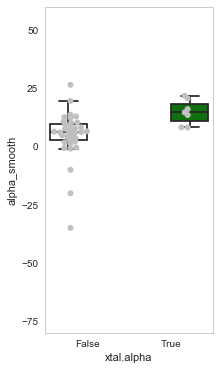

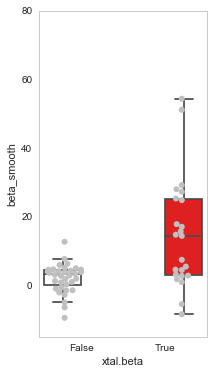

In [330]:
scores = newframe
z = scores

for ss, c in [('alpha', 'green'), ('beta', 'red')]:
    fig, ax = plt.subplots(1)
    fig.set_size_inches(3, 6)
    my_pal1 = {True: c, False: 'white'}
    sns.boxplot(x='xtal.'+ss, y=ss+'_smooth', hue='xtal.'+ss,
                data=scores, ax=ax, palette=my_pal1,
                width=0.9, fliersize=0)
    my_pal2 = {True: 'silver', False: 'silver'}
    sns.swarmplot(x='xtal.'+ss, y=ss+'_smooth', hue='xtal.'+ss,
                  data=scores, ax=ax, s=6, palette=my_pal2, split=True)
    ax.legend([])
    
    if ss == 'alpha':
        ax.set_ylim(-80, 60)
        ax.set_yticks([-75, -50, -25, 0, 25, 50])
    else:
        ax.set_ylim(-15, 80)
    ax.grid(False)
    fig.savefig('../../V3_submission/Instructions_from_NG_forms/raw_components/sf5/RRM-'+ss+'_score_in_xtal_union.svg')

z = scores[~scores['beta_smooth'].isnull()]
b = z['xtal.beta'].astype(bool)

print(len(z[~b]), len(z[b]))
print(stats.ttest_ind(z[~b]['beta_smooth'], z[b]['beta_smooth']))

z = scores[~scores['alpha_smooth'].isnull()]
a = z['xtal.alpha'].astype(bool)
print(stats.ttest_ind(z[~a]['alpha_smooth'], z[a]['alpha_smooth']))

In [121]:
for z in [gb1_scores, ww_scores, rrm_scores]:
    print( np.sum(~z['alpha'].isnull())-2,  np.sum(~z['beta'].isnull())-2)

45 49
24 28
49 61


In [117]:
np.sum(~gb1_scores['beta'].isnull())

51

In [123]:

ww_betastrands = [(17, 22), (26, 31), (36, 38)]

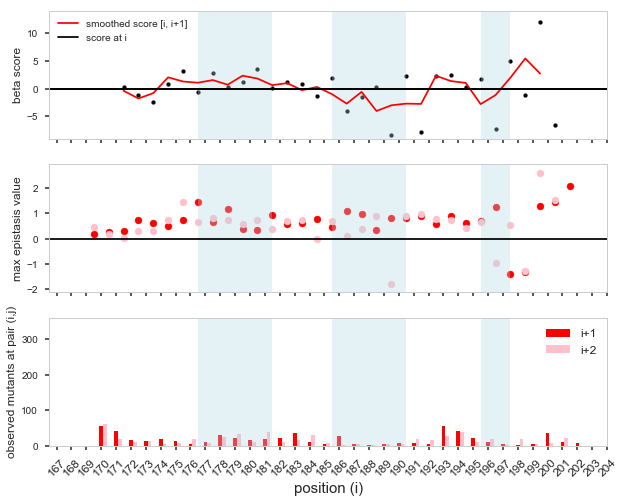

In [124]:
ww_scores = compute_SS(ww_top, e='epi', l=1, r=1, acut=acut, bcut=bcut,
                   na=4, nb=2)
fig, ax = plot_beta_pairs(ww, ww_scores, np.arange(7, 45), o=160)

for (a,b) in ww_betastrands:
    for i in [0, 1, 2]:
        rect = patches.Rectangle((a,-10), b-a, 1000, linewidth=1, edgecolor=None, facecolor='lightblue', alpha=0.33)
        ax[i].add_patch(rect)
        ax[i].grid(False)
        ax[i].tick_params(direction='out', length=4, width=1.5, axis='y')
        ax[i].tick_params(direction='out', length=4, width=1.5, axis='x')
ax[0].set_ylim(-9, 14)

plt.savefig('../../V3_submission/Instructions_from_NG_forms/raw_components/sf5/WW-beta_scores.svg')


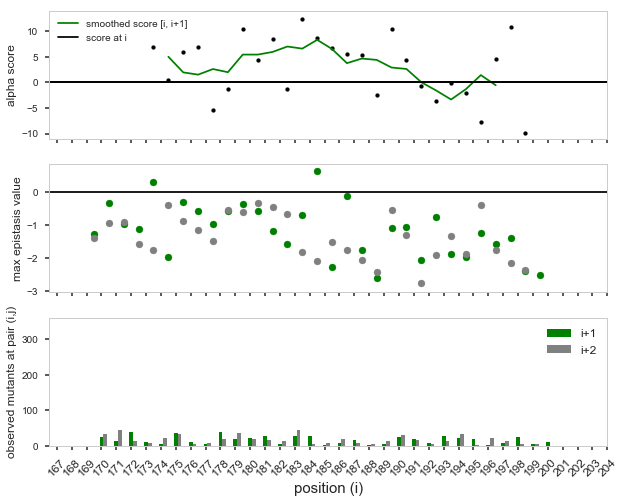

In [128]:
ww_scores = compute_SS(ww_top, e='epi', l=1, r=1, acut=acut, bcut=bcut,
                   na=4, nb=2)
fig, ax = plot_alpha_pairs(ww, ww_scores, np.arange(7, 45), o=160)

for a in ax:
    a.grid(False)
    a.tick_params(direction='out', length=4, width=1.5, axis='y')
    a.tick_params(direction='out', length=4, width=1.5, axis='x')
ax[0].set_ylim(-11, 14)

plt.savefig('../../V3_submission/Instructions_from_NG_forms/raw_components/sf5/WW-alpha_scores.svg')

Ttest_indResult(statistic=1.6277299773477112, pvalue=0.11519726599644577)
Ttest_indResult(statistic=nan, pvalue=nan)


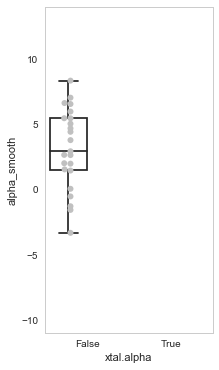

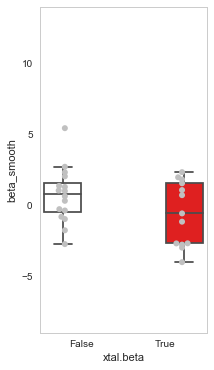

In [127]:
scores = ww_compare_ss
z = scores

for ss, c in [('alpha', 'green'), ('beta', 'red')]:
    fig, ax = plt.subplots(1)
    fig.set_size_inches(3, 6)
    my_pal1 = {True: c, False: 'white'}
    sns.boxplot(x='xtal.'+ss, y=ss+'_smooth', hue='xtal.'+ss,
                data=scores, ax=ax, palette=my_pal1,
                width=0.9, fliersize=0)
    my_pal2 = {True: 'silver', False: 'silver'}
    sns.swarmplot(x='xtal.'+ss, y=ss+'_smooth', hue='xtal.'+ss,
                  data=scores, ax=ax, s=6, palette=my_pal2, split=True)
    ax.legend([])
    
    if ss == 'alpha':
        ax.set_ylim(-11, 14)
        #ax.set_yticks([-75, -50, -25, 0, 25, 50])
    else:
        ax.set_ylim(-9, 14)
    ax.grid(False)
    fig.savefig('../../V3_submission/Instructions_from_NG_forms/raw_components/sf5/WW_'+ss+'_score_in_xtal_union.svg')

z = scores[~scores['beta_smooth'].isnull()]
b = z['xtal.beta']
print(stats.ttest_ind(z[~b]['beta_smooth'], z[b]['beta_smooth']))

z = scores[~scores['alpha_smooth'].isnull()]
a = z['xtal.alpha']
print(stats.ttest_ind(z[~a]['alpha_smooth'], z[a]['alpha_smooth']))

In [130]:
rrm_top.sort_values('epi', ascending=False).head()

,mut,positions,mut.aminos,wt.aminos,lnW,lnWs,lnW.proj,lnW.cap,epi,Enrichment,i,A_i,mut.i,j,A_j,mut.j,LR,epi.abs,num.muts
893,"[['N127K', 'D138N']]","(127, 138)","('K', 'N')","('N', 'D')",-0.736587,"[-0.9732944450376324, -0.029271088992765176]",-1.002566,-1.002566,0.265978,0.183406,127,[,['N127K',138,,'D138N'],True,1.002566,47
98,"[['G177I', 'G193S']]","(177, 193)","('I', 'S')","('G', 'G')",0.322152,"[0.05791630865876396, 0.02041104836917089]",0.078327,0.078327,0.243824,2.099673,177,[,['G177I',193,,'G193S'],True,0.078327,46
393,"[['A182S', 'L191I']]","(182, 191)","('S', 'I')","('A', 'L')",0.267239,"[-0.037370609756588305, 0.06267501330215804]",0.025304,0.025304,0.241935,1.850286,182,[,['A182S',191,,'L191I'],True,0.025304,33
864,"[['L153M', 'S154C']]","(153, 154)","('M', 'C')","('L', 'S')",-0.165485,"[-0.012254716305262026, -0.3929831091710562]",-0.405238,-0.405238,0.239753,0.683148,153,[,['L153M',154,,'S154C'],False,0.405238,32
896,"[['N127K', 'I137L']]","(127, 137)","('K', 'L')","('N', 'I')",-0.831941,"[-0.9732944450376324, -0.09636649496166359]",-1.069661,-1.069661,0.237720,0.147251,127,[,['N127K',137,,'I137L'],True,1.069661,45


In [129]:
rrm_top.head()

,mut,positions,mut.aminos,wt.aminos,lnW,lnWs,lnW.proj,lnW.cap,epi,Enrichment,i,A_i,mut.i,j,A_j,mut.j,LR,epi.abs,num.muts
0,"[['G177R', 'P200C']]","(177, 200)","('R', 'C')","('G', 'P')",0.109041,"[-0.01757819195471978, 0.37655820498379916]",0.358980,0.358980,-0.249939,1.285407,177,[,['G177R',200,,'P200C'],True,0.358980,38
1,"[['A141C', 'L142F']]","(141, 142)","('C', 'F')","('A', 'L')",0.099838,"[0.1791316628819801, 0.022905863870589654]",0.202038,0.202038,-0.102199,1.258456,141,[,['A141C',142,,'L142F'],False,0.202038,28
2,"[['H134P', 'A141C']]","(134, 141)","('P', 'C')","('H', 'A')",0.026944,"[0.017407555322442904, 0.1791316628819801]",0.196539,0.196539,-0.169595,1.064006,134,[,['H134P',141,,'A141C'],True,0.196539,46
3,"[['N187A', 'Q194H']]","(187, 194)","('A', 'H')","('N', 'Q')",0.072459,"[0.14866297035801002, 0.043932916492504706]",0.192596,0.192596,-0.120137,1.181569,187,[,['N187A',194,,'Q194H'],True,0.192596,57
4,"[['G188R', 'V198I']]","(188, 198)","('R', 'I')","('G', 'V')",0.081602,"[0.10703033069619777, 0.06836119891316543]",0.175392,0.175392,-0.093789,1.206708,188,[,['G188R',198,,'V198I'],True,0.175392,30


In [338]:
k = 0
for i in test4.index:
    if i - k > 1:
        print( k, i)
    k = i
    

0 126
149 151
174 176


In [344]:
newframe.loc[:, 'i'] = list(np.arange(126, 150)) + list(np.arange(151, 175)) + list(np.arange(176, 200))

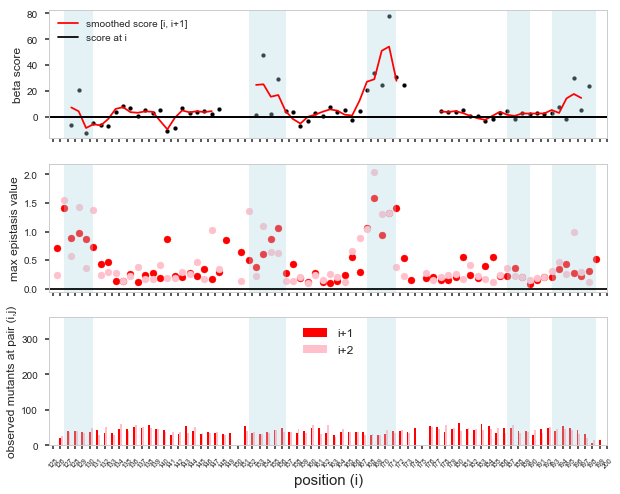

In [349]:
rrm_scores = newframe#compute_SS(rrm_top, e='epi', l=1, r=1, acut=acut, bcut=bcut,
             #      na=4, nb=2)
fig, ax = plot_beta_pairs(rrm, rrm_scores, np.arange(125, 201), o=0, fs=7)

for (a,b) in rrm_betastrands:
    for i in [0, 1, 2]:
        rect = patches.Rectangle((a,-20), b-a, 400, linewidth=1, edgecolor=None, facecolor='lightblue', alpha=0.33)
        ax[i].add_patch(rect)
        ax[i].grid(False)
        ax[i].tick_params(direction='out', length=4, width=1.5, axis='y')
        ax[i].tick_params(direction='out', length=4, width=1.5, axis='x')

#ax[0].set_ylim(-15, 80)
#plt.show()

fig.savefig('../../V3_submission/Instructions_from_NG_forms/raw_components/sf5/RRM-beta_scores2.svg')


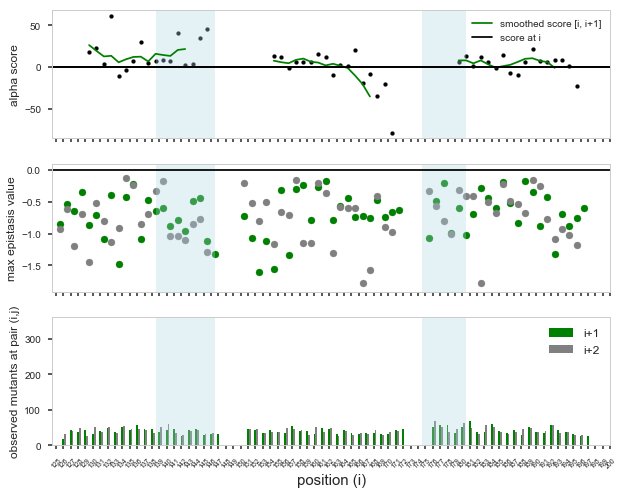

In [350]:
rrm_scores = newframe#compute_SS(rrm_top, e='epi', l=1, r=1, acut=acut, bcut=bcut,
             #      na=4, nb=2)
fig, ax = plot_alpha_pairs(rrm, rrm_scores, np.arange(125, 201), o=0, fs=7)

for (a,b) in rrm_helices:
    for i in [0, 1, 2]:
        rect = patches.Rectangle((a,-100), b-a, 500, linewidth=1, edgecolor=None, facecolor='lightblue', alpha=0.33)
        ax[i].add_patch(rect)
        ax[i].grid(False)
        
        ax[i].tick_params(direction='out', length=4, width=1.5, axis='y')
        ax[i].tick_params(direction='out', length=4, width=1.5, axis='x')
#ax[0].set_ylim(-80, 60)
plt.show()

fig.savefig('../../V3_submission/Instructions_from_NG_forms/raw_components/sf5/rrm_alpha_coverage_and_scores.png', dpi=300)

In [24]:
?a.set_position

Signature: a.set_position(pos, which='both')
Docstring:
Set the axes position

The expected shape of ``pos`` is::

  pos = [left, bottom, width, height]

in relative 0,1 coords, or *pos* can be a
:class:`~matplotlib.transforms.Bbox`

There are two position variables: one which is ultimately
used, but which may be modified by :meth:`apply_aspect`, and a
second which is the starting point for :meth:`apply_aspect`.


Optional keyword arguments:
  *which*

    ==========   ====================
    value        description
    ==========   ====================
    'active'     to change the first
    'original'   to change the second
    'both'       to change both
    ==========   ====================
File:      ~/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py
Type:      method


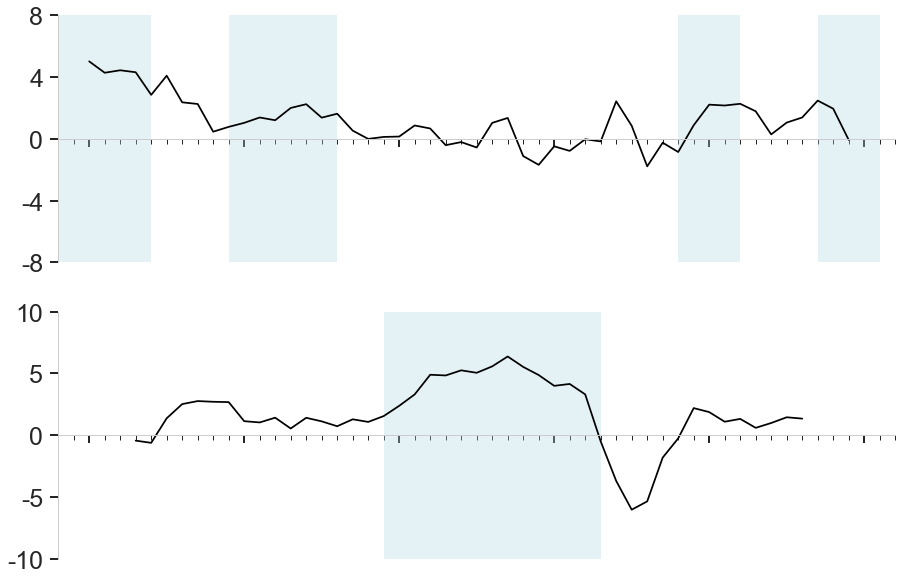

In [29]:
scores = gb1_2ndary

gb1_betastrands = [(228, 234), (239, 246), (268, 272), (277, 281)]
gb1_helix = (249, 263)

fig, ax = plt.subplots(2, 1)
fig.set_size_inches(15, 10)

#ax[0].scatter(scores['i'], scores['beta'])
ax[0].plot(scores['i'], smooth(scores['beta'], 2), color='black')
    

#ax[1].scatter(scores['i'], scores['alpha'])
ax[1].plot(scores['i'], smooth(scores['alpha'], 4), color='black')



for (a,b) in gb1_betastrands:
    rect = patches.Rectangle((a,-10), b-a, 22, linewidth=1, edgecolor=None, facecolor='lightblue', alpha=0.33)
    ax[0].add_patch(rect)

rect = patches.Rectangle((gb1_helix[0],-30), gb1_helix[1]-gb1_helix[0], 60, linewidth=1, edgecolor=None, facecolor='lightblue', alpha=0.33)
ax[1].add_patch(rect)

ax[0].set_xlim(228, 282)
ax[1].set_xlim(228, 282)

n=10
ax[0].set_xticks(np.arange(230, 283, n), minor=False)
ax[1].set_xticks(np.arange(230, 283, n), minor=False)
ax[0].set_xticklabels([]) # np.arange(230, 283, n), minor=False, fontsize=18)
ax[1].set_xticklabels([]) #np.arange(230, 283, n), minor=False, fontsize=18)
ax[0].set_xticks(np.arange(228, 283), minor=True)
ax[1].set_xticks(np.arange(228, 283), minor=True)

ax[0].set_yticks([-8, -4, 0, 4, 8])#, minor=True)
#ax[0].set_yticks([0], minor=True)
#ax[1].set_yticks([0], minor=True)
ax[0].set_yticklabels([-8, -4, 0, 4, 8], fontsize=25)
ax[1].set_yticks([-10, -5, 0, 5, 10])
ax[1].set_yticklabels([-10, -5, 0, 5, 10], fontsize=25)#, minor=True)


ax[0].tick_params(width=2, length=8, which='major')
ax[0].tick_params(width=1, length=5, which='minor')
ax[1].tick_params(width=2, length=8, which='major')
ax[1].tick_params(width=1, length=5, which='minor')

ax[0].grid(False)
ax[1].grid(False)
ax[0].grid(False)
ax[1].grid(False)

for a in ax:
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    a.spines['bottom'].set_position('center')
#    a.spines["bottom"].set_visible(False)


fig.savefig('../../final_formatted_submission/raw_components/Fig1_2ndary_struct.svg')
#ax[0].tick_params(top='off', bottom='on', left='on', right='off') #, labelleft='off', labelbottom='on')

# Contact prediction and folding from smaller libraries

### Experimental strategies for mutant libraries

In [884]:
any_pair = gb1[gb1['Input Count'].gt(20)]
one_del = any_pair[any_pair['lnWs'].apply(lambda x: (x[0] < -2) or (x[1] > -2))]
both_del = any_pair[any_pair['lnWs'].apply(lambda x: (x[0] < -2) and (x[1] > -2))]

### Sampling and measuring 3D contact precision

In [888]:
library_sizes = np.array([0.005, 0.01, 0.02, 0.05]) *  len(gb1)
library_sizes = library_sizes.astype(int)

sample_precisions(both_del, library_sizes, num_draws=2)

,library size,L/2,L,L/2 (i-j > 5),L (i-j > 5)
0,2679,0.428571,0.339286,0.214286,0.232143
1,5359,0.535714,0.482143,0.428571,0.321429
2,10718,0.714286,0.571429,0.500000,0.321429
3,26795,0.785714,0.607143,0.535714,0.375000


### Sampling constraints for folding

In [895]:
sampled_epi_pairs = sample_constraints(both_del, library_sizes, num_draws=5)

# return one table as an example
sampled_epi_pairs[library_sizes[0]][0].head()

,A_i,A_j,cn,i,j
0,L,Y,3.080727,233,259
1,V,D,2.793050,265,266
2,G,V,2.372401,267,280
3,L,D,2.227567,233,266
4,T,E,2.153573,281,282


## additional mutation strategy: pairwise swaps

In [855]:
gb1_swaps = gb1[gb1['mut'].apply(lambda x: (x[0][-1] == x[1][0]) or (x[1][-1] == x[0][0])) & gb1['Input Count'].gt(20)]
gb1_swaps_top = gb1_swaps.sort_values('epi', ascending=False).drop_duplicates('positions', keep='first')

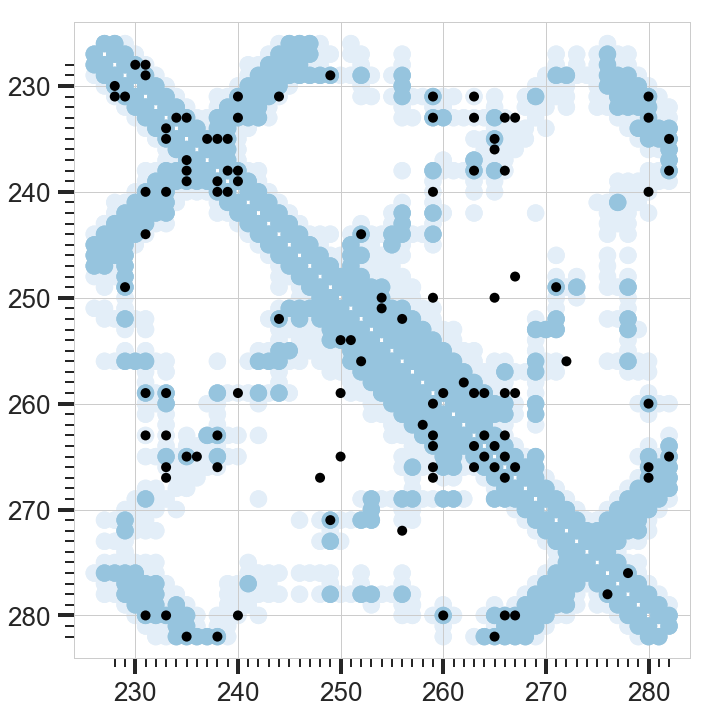

In [856]:
xt = gb1_xtals.reset_index()
xt.loc[:, 'positions'] = xt.apply(lambda x: (x['level_0'], x['level_1']), axis=1)

for d in ['min_overall']:
    fig, ax = plotContacts(xt, lims=[226, 56+226], offset=226, dist=d, tixm=(228, 283), tixM=(230, 290))
    plotIJ(gb1_swaps_top.head(56), ax=ax, z=2, s=100)
    ax.tick_params(width=4, length=16, which='major')
    ax.tick_params(width=2, length=9, which='minor')
    fig.tight_layout()
    
    plt.grid(True, which='major')
    #fig.savefig('../additional_data/gb1_swaps-100-pairs-vs-'+d+'_10grid-b10.svg')

# Extra analyses (not in the paper):

## Precision vs epistasis rank

### precision of L pairs, at descending epistasis rank (pairs ranked from N -> N+L)

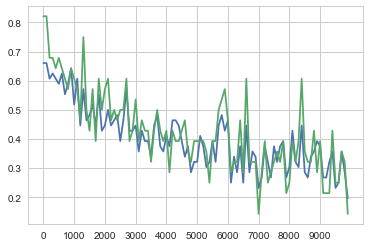

In [666]:
def rolling_top_L_precision(tbl, L, n = 100, M = 56, d='dist.any_struct'):
    '''precision of L pairs, at descending epistasis
    rank (pairs ranked from N -> N+L)'''
    l = []
    for i in np.arange(L)[::n]:
        z = np.mean(tbl.tail(len(tbl) - i).drop_duplicates(
            'positions').head(M)[d].lt(5))
        l.append(z)
    return(l)

L = 10000
n = 100

# L and L/2
M = 56
plt.plot(np.arange(L)[::n], rolling_top_L_precision(gb1_top, L, n, 56))
plt.plot(np.arange(L)[::n], rolling_top_L_precision(gb1_top, L, n, 28))

plt.gca().set_xticks(np.arange(0, 10000)[::1000]);

### < 5A precision of top N pairs (pairs ranked from 1 -> N)

Precision falls off steeply after the top L most epistatic pairs- note: this will be a property of any metric that ranks true 3D contacts towards the top, because there are only so many contacts total (a # proportional to L).

/Users/nrollins/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


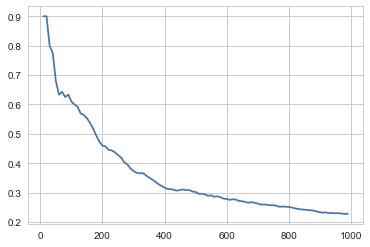

In [924]:
def rolling_precision(tbl, L = 100, n = 5, d='dist.any_struct'):
    '''precision of the top N pairs (ranked from 1 -> N)'''
    l = []
    for i in np.arange(L)[::n]:
        l.append(np.mean(tbl.head(i).drop_duplicates(
            'positions')[d].lt(5)))
    return(l)

L = 1000
n = 10

plt.plot(np.arange(L)[::n], rolling_precision(gb1_top, L, n))

# alternative approaches: limit pairs per position, no measurement floor correction, average product correction

## limit pairs per position

In [834]:
gb1_top_dedup = dedup_sites(gb1_top, n=3)

## no measurement floor correction

In [ ]:
gb1.loc[:, 'epi.nocap'] = gb1.apply(
    lambda x: x['lnW'] - np.sum(x['lnWs']), axis=1)

## average product correction

In [926]:
gb1_top_apc = APC(gb1_top, 'epi')
gb1_nocap_apc = APC(gb1_top_nocap, 'epi.nocap')

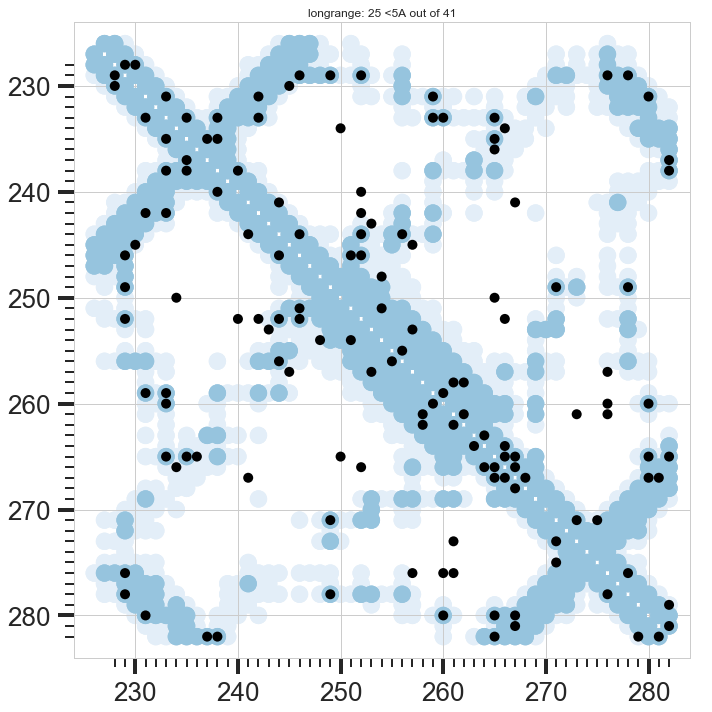

In [927]:
xt = gb1_xtals.reset_index()
xt.loc[:, 'positions'] = xt.apply(lambda x: (x['level_0'], x['level_1']), axis=1)

X = gb1_top_apc
N = 70

for d in ['min_overall']:
    top = X.head(N)

    fig, ax = plotContacts(xt, lims=[226, 56+226], offset=226, dist=d, tixm=(228, 283), tixM=(230, 290))
    plotIJ(top, ax=ax, z=2, s=100)
    ax.tick_params(width=4, length=16, which='major')
    ax.tick_params(width=2, length=9, which='minor')
    plt.grid(True, which='major')
    fig.tight_layout()
    
    lr = top[top['LR']]
    n = np.sum(lr['dist.any_struct'].lt(5))
    ax.set_title('longrange: ' + str(n) + ' <5A out of ' + str(len(lr)) )

#fig.savefig('../other/gb1_top'+str(N)+'LRpairs_no_floor_correction--with_APC.png', dpi=250)

# Reporting precision tables

In [1013]:
Lbasic = [5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 150, 200]
jobs = [
    ('GB1', Lbasic + [28, 56], gb1_top),
    ('WW ', Lbasic + [18, 36], ww_top),
    ('RRM', Lbasic + [38, 75], rrm_top),
    ('FosJun', Lbasic + [16, 32], fosjun_top),
    ('Twister', Lbasic + [24, 48], twister_top),
    ('GFP', Lbasic + [119, 238], gfp_top)
]

with pd.ExcelWriter('precision_tables.xlsx') as myexcel:
    for tag, Ls, dms in jobs:
        rows = [str(l) for l in Ls] + ['LR ' + str(l) for l in Ls]
        result = precision_table(dms, Ls).loc[:, rows].T
        result.to_excel(myexcel, sheet_name=tag)

## Writing out secondary structure files

In [1019]:
with pd.ExcelWriter('ss_comparison34232.xlsx') as myexcel:
    gb1_compare_ss.to_excel(myexcel, sheet_name='GB1')
    ww_compare_ss.to_excel(myexcel, sheet_name='WW')
    rrm_compare_ss.to_excel(myexcel, sheet_name='RRM')

## Writing out precision tables

In [1078]:
Lbasic = [5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 150, 200]
jobs = [
    ('GB1', Lbasic + [28, 56], gb1_top),
    ('WW ', Lbasic + [18, 36], ww_top),
    ('RRM', Lbasic + [38, 75], rrm_top),
    ('FosJun', Lbasic + [16, 32], fosjun_top),
    ('Twister', Lbasic + [24, 48], twister_top),
    ('GFP', Lbasic + [119, 238], gfp_top)
]

with pd.ExcelWriter('precision_tables.xlsx') as myexcel:
    for tag, Ls, dms in jobs:
        rows = [str(l) for l in Ls] + ['LR ' + str(l) for l in Ls]
        result = precision_table(dms, Ls).loc[:, rows].T
        result.to_excel(myexcel, sheet_name=tag)